# TP2 : démultiplexage stéréophonique

Aujourd'hui, l'ensemble des données sonores rendues disponibles par la radio ou par la télévision est de nature stéréophonique. Néanmoins, historiquement, cela n'a pas toujours été le cas. A l'origine, les transmissions étaient en effet *monophoniques*, simplement restituées à partir d'un seul haut-parleur. Ainsi, lors du passage à
la stéréo, il a fallu veiller à ce que l'information audio stéréophonique soit représentée de sorte que les anciens équipements monophoniques restent compatibles. De plus, de nombreux postes radio basiques (radio-réveils, etc.) sont aujourd'hui toujours en vente, et diffusent un son uniquement monophonique.

Concrètement, la création, la transmission et la réception d'un signal stéréophonique s'opèrent de la façon suivante :
<img src="img/transmission.png" width=600>

- Tout d'abord, *un seul et unique signal* $x_{\text{stéréo}}[n]$, contenant l'information stéréophonique gauche et droite, est obtenu à partir d'un *multiplexeur stéréophonique* ;
- Ensuite, cet unique signal est transmis (par exemple, à l'aide  d'une modulation de fréquence) ;
- Puis, l'appareil de réception doit démoduler le signal reçu afin d'obtenir le signal $\hat{x}_{\text{stéréo}}[n]$, signal stéréophonique reçu qu'on espère quasi-identique au signal $x_{\text{stéréo}}[n]$ émis.
- Enfin, sur la base du signal stéréphonique reçu, un *démultiplexeur stéréo* permet de restituer indépendemment les signaux gauche et droit initiaux.

**C'est cette dernière opération que nous allons étudier ici**

La contrainte principale pour une telle transmission, comme mentionné auparavant, est que le signal doit tout de même pouvoir être reçu par des récepteurs non équipés pour la stéréophonie.  Cette compatibilité avec les postes monophoniques est obtenue en combinant les signaux des voies droite (D) et gauche (G) et en leur attribuant une occupation spectrale bien identifiée (et normalisée). Ainsi, l'allure du contenu fréquentiel (TFSD) du signal stéréophonique $x_{\text{stéréo}}[n]$ est représenté sur la figure suivante (tracé limité entre 0 et 53kHz) :
<img src="img/spectre.png" width=600>
<p style="text-align: center;">Fig.1 : Spectre du signal stéréophonique</p>

## Objectif
*L'objectif de ce TP est de proposer une solution, à base de filtrage numérique, permettant d'extraire du signal $x_{\text{stéréo}}[n]$ les deux signaux d'origine G et D. Idéalement, ces deux signaux doivent être parfaitement séparés, de façon à garantir une reproduction stéréophonique de qualité. Nous verrons que cela n'est possible que
sous certaines conditions que nous allons mettre en évidence dans la suite.*


In [1]:
%matplotlib notebook
#%matplotlib inline
import numpy as np
from IPython.display import display, Audio
import pylab as plt
from scipy.io.matlab import mio
from filtres import filtre
from demultiplex import demultiplex
%load_ext autoreload
%autoreload 2

# 1/ Analyse du signal stéréophonique

Nous allons dans un premier temps analyser le signal stéréophonique fourni, et vérifier qu'il possède les caractéristiques attendues.

#### 1.1) On suppose que le signal stéréophonique est échantillonné à une fréquence $f_e = 132300$ Hz. Justifier le choix de cette fréquence d'échantillonnage.

Sur l'allure du contenu fréquentiel du signal stéréo, on constate que $f_{max}$ est de 53kHz. Par conséquent, la fréquence d'échantillonage minimale est $fe_{min} = 2*f_{max} = 106kHz$. La fréquence fe choisie respecte donc le théorème de Shannon.

#### 1.2) Charger le signal stéréophonique et tracer son allure temporelle. Commenter le résultat obtenu.

In [2]:
x = mio.loadmat('stereo.mat')
stereo = np.array(x['stereo'])[0]
Fe = 132300

<IPython.core.display.Javascript object>


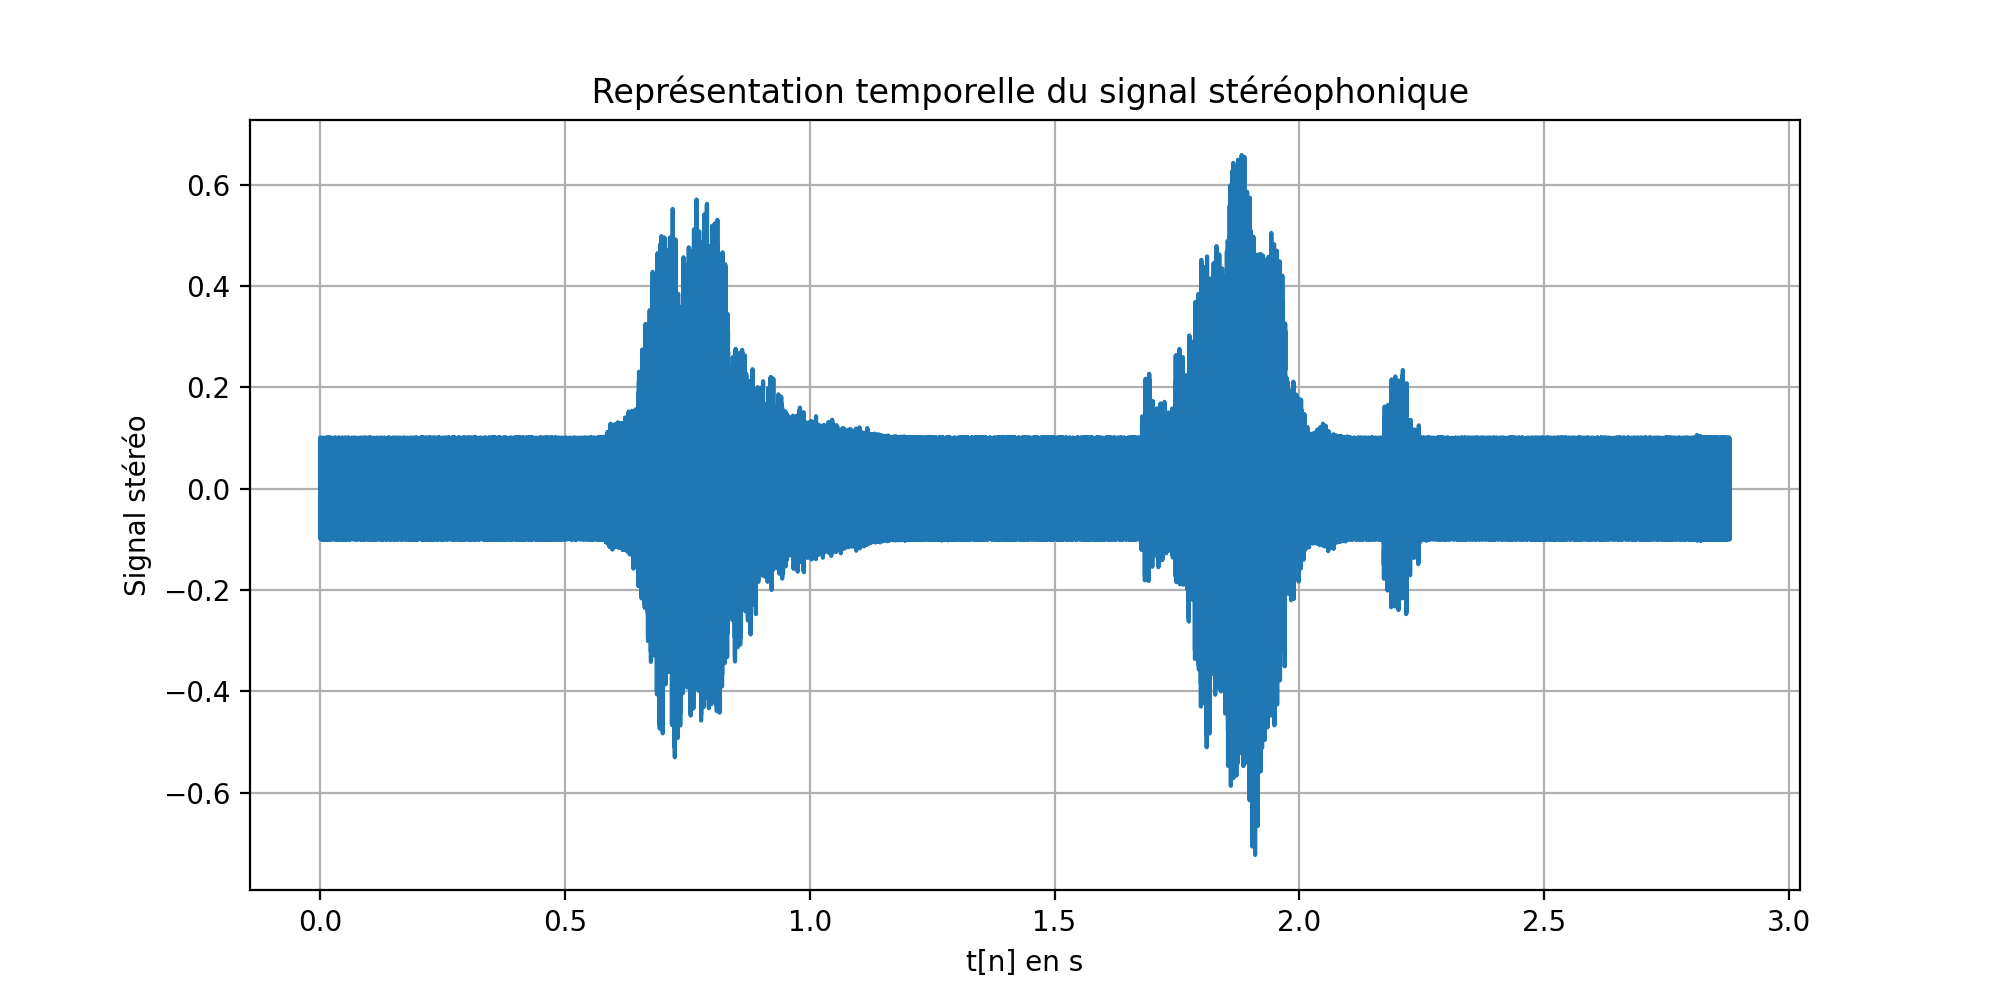

In [4]:
# Code à compléter
N = len(stereo)
Te = 1/Fe
t = np.arange(0, N*Te, Te)
plt.figure(figsize=(10,5))
plt.plot(t,stereo)
plt.xlabel('t[n] en s')
plt.ylabel('Signal stéréo')
plt.title(u'\n Représentation temporelle du signal stéréophonique')
plt.grid()

*Commentaires sur le tracé temporel :*

En zoomant sur le signal, on constate la présence d'un signal sinoidal, visiblement mélangé à "autre chose".

#### 1.3) Analyser en fréquence le signal stéréophonique. Montrer que l'on retrouve un contenu fréquentiel proche de celui attendu. Préciser alors la bande passante du signal.

<IPython.core.display.Javascript object>


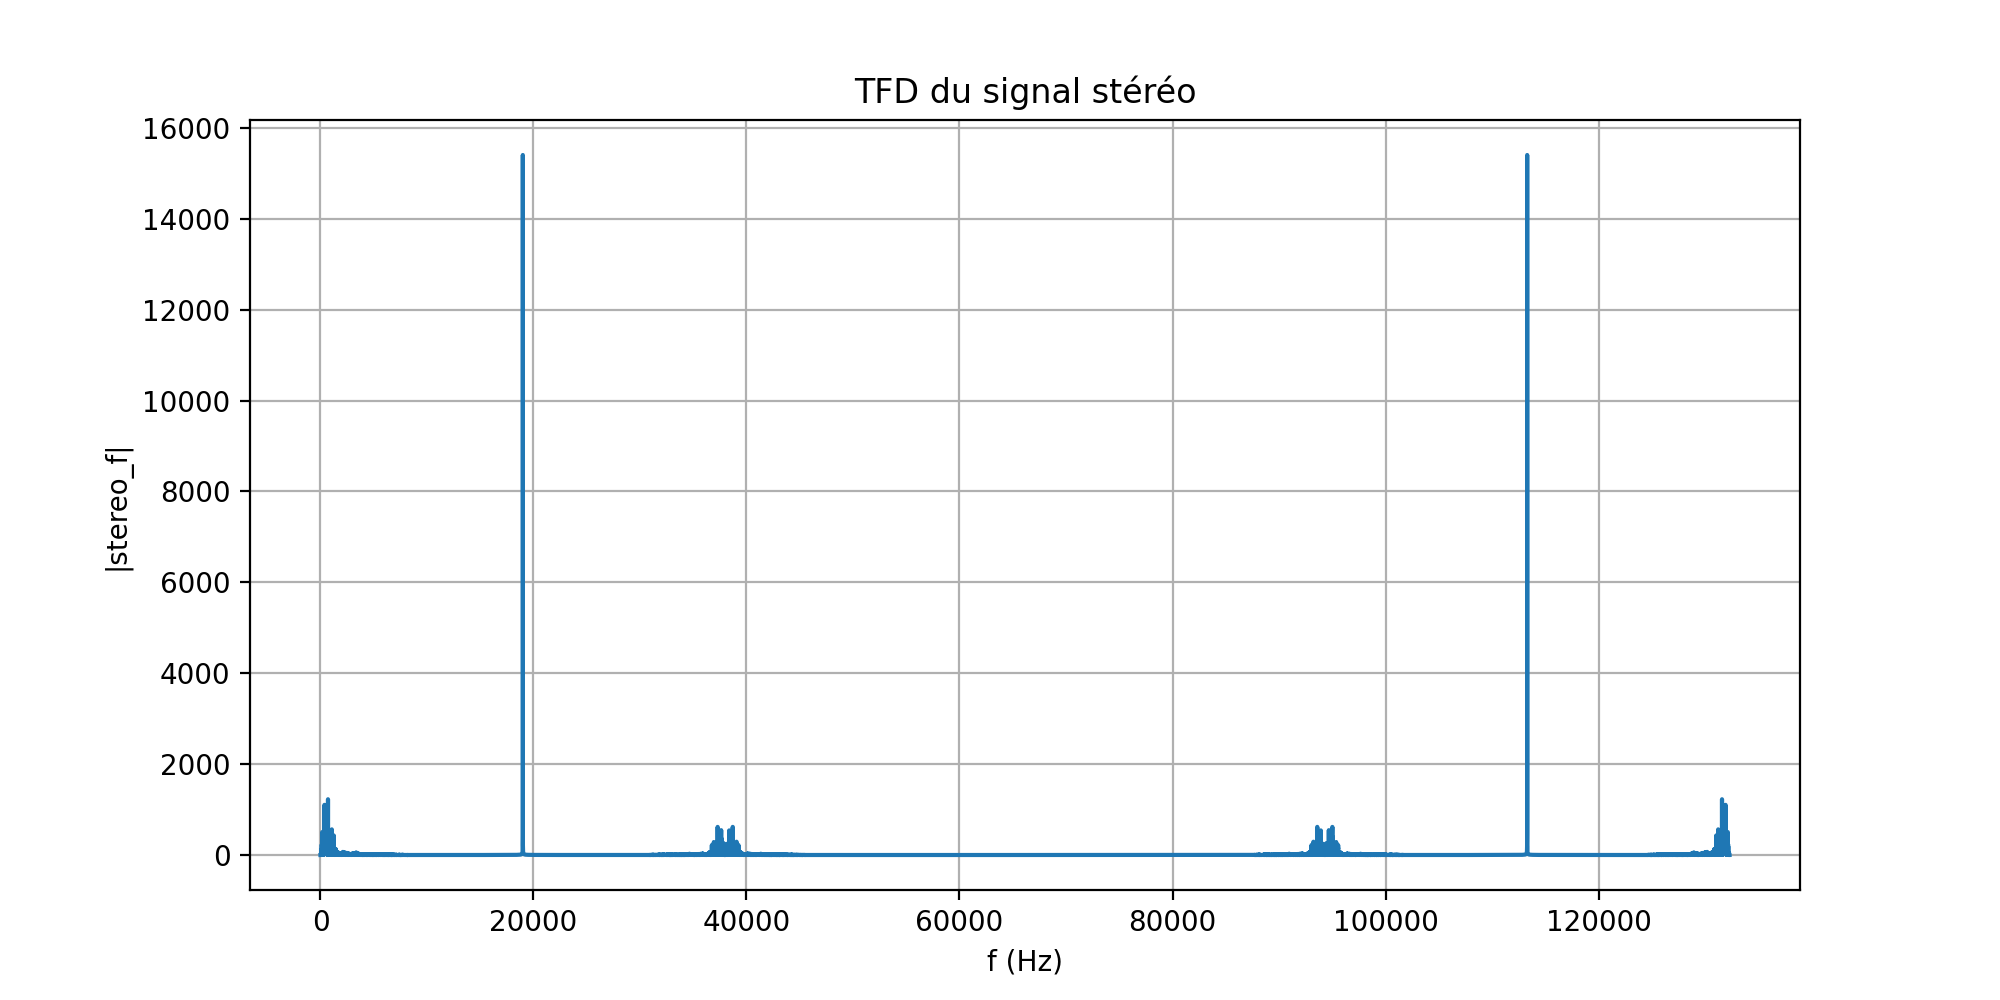

In [5]:
# Code à compléter
f = np.arange(0,Fe,Fe/N)
stereo_f = np.fft.fft(stereo)
plt.figure(figsize=(10,5))
plt.plot(f,abs(stereo_f))
plt.title('TFD du signal stéréo'); plt.xlabel('f (Hz)'); plt.ylabel('|stereo_f|'); plt.grid()

*Commentaires sur la courbe :*

On retrouve le contenu fréquentiel attendu pour le signal stéréo :
- G+D (le signal monophonique), dans sa bande de base (0-15kHz). Ici, l'étendue spectrale n'atteint pas 15kHz et ne dépasse pas environ 4kHz.
- la porteuse à sa 1/2 fréquence = 19kHz
- G-D, décalé autour de la fréquence porteuse à 38kHz (modulation d'amplitude sans porteuse).

*Bande passante du signal stéréophonique :*

On mesure ici $f_{max}$ à environ 42kHz. En pratique, $f_{max}$ est susceptible d'atteindre 38k + 15k = 53kHz.

# 2/ Démultiplexage stéréophonique

Maintenant que nous avons étudié les caractéristiques du signal stéréphonique, nous allons maintenant chercher à en extraire les deux signaux gauche (G) et droite (D). Pour cela, l'architecture suivante est utilisée :
<img src="img/archi.png" width=600>
<p style="text-align: center;">Fig.2 : Schéma de principe du démultiplexeur stéréo.</p>

Sur ce schéma sont indiqués en bleu les différents traitement que vous avez à réaliser. En particulier :
- le signal G+D (i.e. le signal monophonique) est extrait du signal stéréophonique par un filtre **FILTRE1** que vous aurez à spécifier et réaliser **dans la partie 2.1** ;
- la porteuse à 19kHz est extraite du signal stéréophonique par un filtre **FILTRE2** étudié **dans la partie 2.2** ;
- la sortie de **FILTRE2** est alors exploitée avec d'autres filtres et traitements élémentaires pour retrouver le signal G-D
- enfin, disposant des 2 signaux G+D et G-D, vous pourrez combiner ces signaux afin d'obtnir les signaux séparés G et D **dans la partie 2.3**.

## 2.1/ Extraction du signal monophonique

Une première étape du traitement visant à extraire les signaux G et D seuls consiste à extraire tout d'abord le signal G+D. Celui-ci correspond au signal monophonique qui sera émis par tous les postes non compatibles avec la stéréo. Cette opération est effectuée par un filtre numérique **FILTRE1** appliqué au signal stéréo $x_{stereo}(t)$.

#### 2.1.1) Sur quelle bande de fréquence se situe le signal G+D ? En déduire la nature (passe-haut, passe-bas, passe-bande) du filtre permettant d'extraire G+D du signal stéréo.

Le signal G+D se situe en général dans la bande 0-15kHz. Dans le cas des signaux utilisés dans ce TP, l'étendue spectrale du signal monophonique ne dépasse pas 4 à 5 kHz.
Il s'agit donc de suppimer, dans le cas général, toutes les férquences supérieures à 15kHz. Il faudra donc utiliser un filtre passe-bas.

#### 2.1.2) Proposer alors le gabarit du filtre à synthétiser.

Il s'agit de supprimer les fréquences supérieures à 15kHz. On a donc fc = 15kHz. Il faut aussi que le filtre atténue suffisemment les fréquences au delà de 15kHz, et en particulier la fréquence porteuse de fréquence 19kHz. La bande de transition du filtre est donc petite (4kHz max) et doit permettre d'atteindre une atténuation significative (pas de valeur évidente à donner à ce stade, mais certainement plus de 30 dB) à 19kHz.

#### 2.1.3) Synthétiser un filtre RIF et RII satisfaisant le gabarit précent à l'aide de l'outils filtre() fourni.

<IPython.core.display.Javascript object>


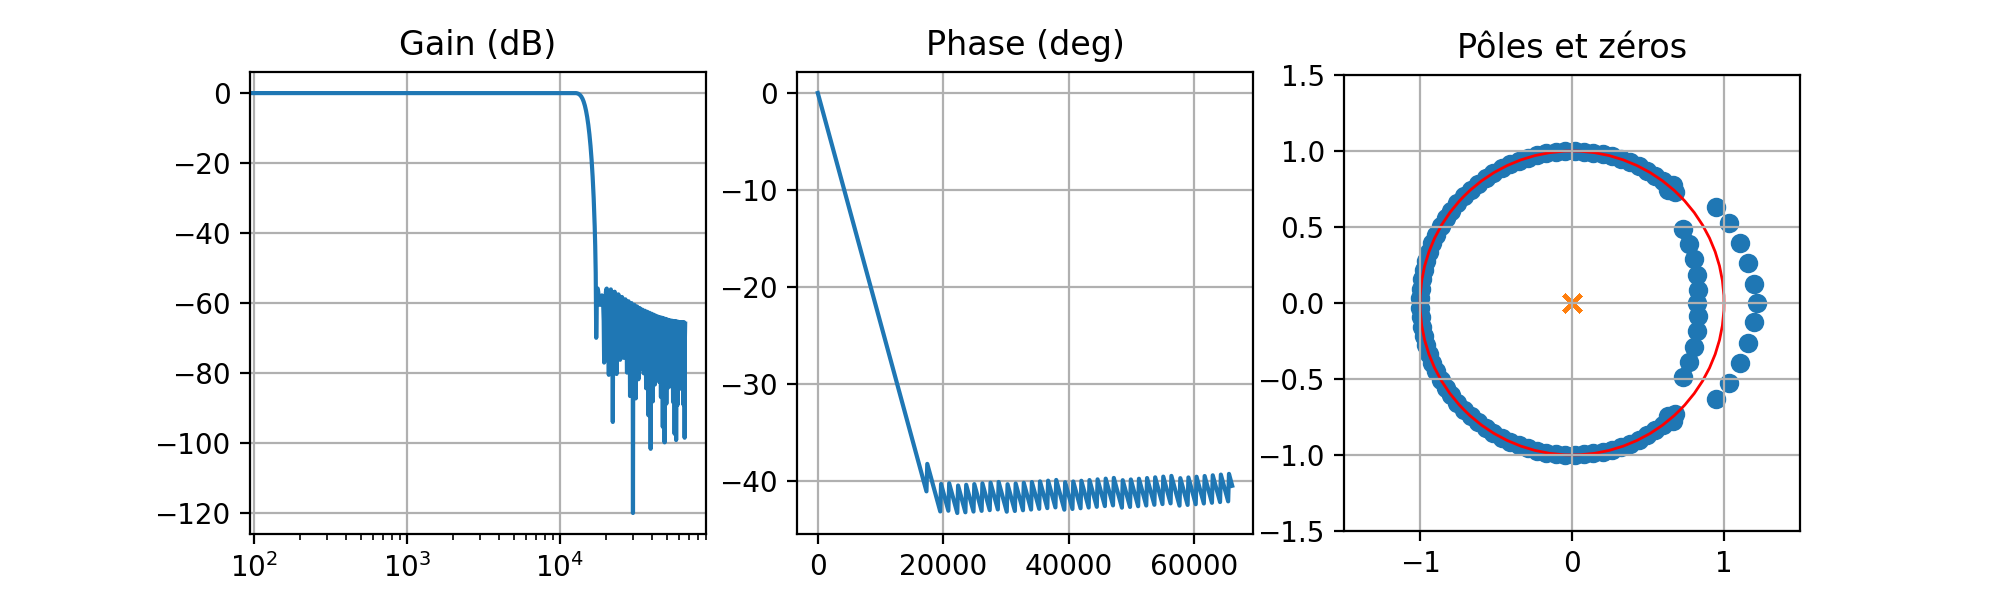

No handles with labels found to put in legend.


In [9]:
# Filtre RIF
FILTRE1_RIF = filtre()
fig, ax = plt.subplots(1,3,figsize=(10,3))
FILTRE1_RIF.display(ax, fig)

<IPython.core.display.Javascript object>


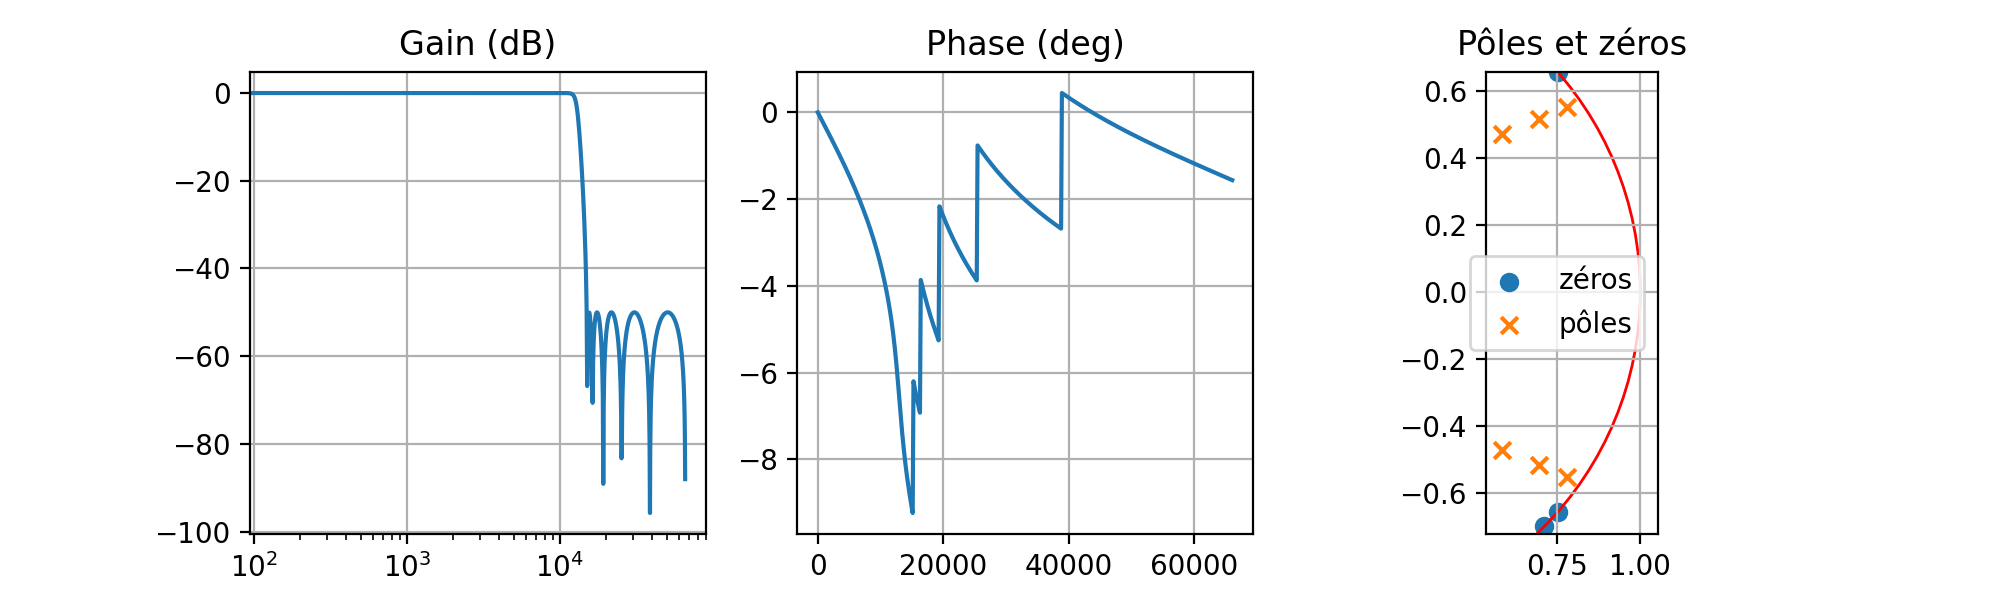

In [10]:
# Filtre RII
FILTRE1_RII = filtre()
fig, ax = plt.subplots(1,3,figsize=(10,3))
FILTRE1_RII.display(ax, fig)

#### 2.1.4) Comparer les réponses en fréquence (en gain et phase !) des deux filtres obtenus. En quoi ces réponses sont-elles différentes ? Quel est, selon vous, le "meilleur" filtre ?

La réponse en fréquence du filtre RIF est plus "douce", et nécessite de faire appel à un ordre élevé afin de satisfaire le gabarit. A l'opposé, le filtre RII semble satisfaire le cahier des charges dès un ordre plutôt faible. On constate que la phase du filtre RIF varie linéairement avec la fréquence, ce qui n'est pas le cas du filtre RII. 
Dans tous les cas, sous réserve d'adapter les paramètres au problème, les deux types de filtre semblent permettre de récupérer correctement le signal monophonique.

#### 2.1.5) Visualiser les réponses impulsionnelles des deux filtres RIF et RII obtenus. Commenter et comparer leur allure.

<IPython.core.display.Javascript object>


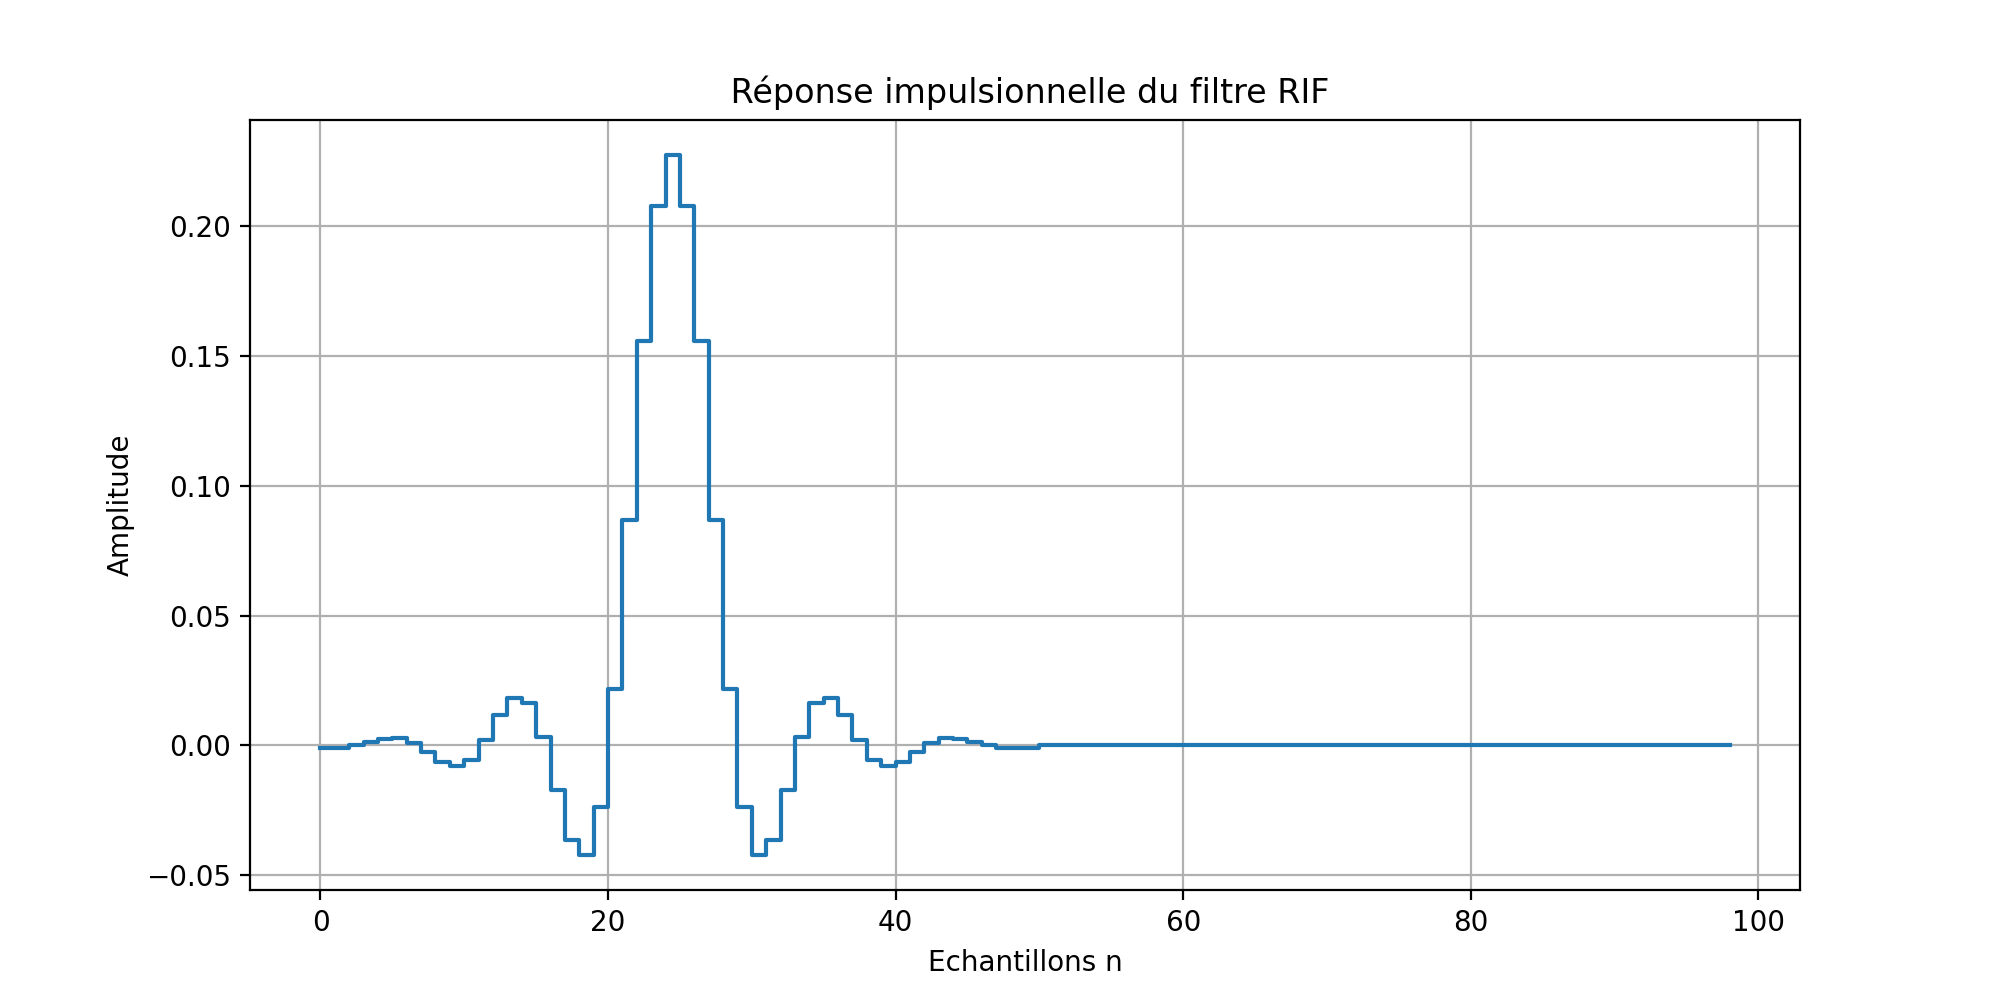

<IPython.core.display.Javascript object>


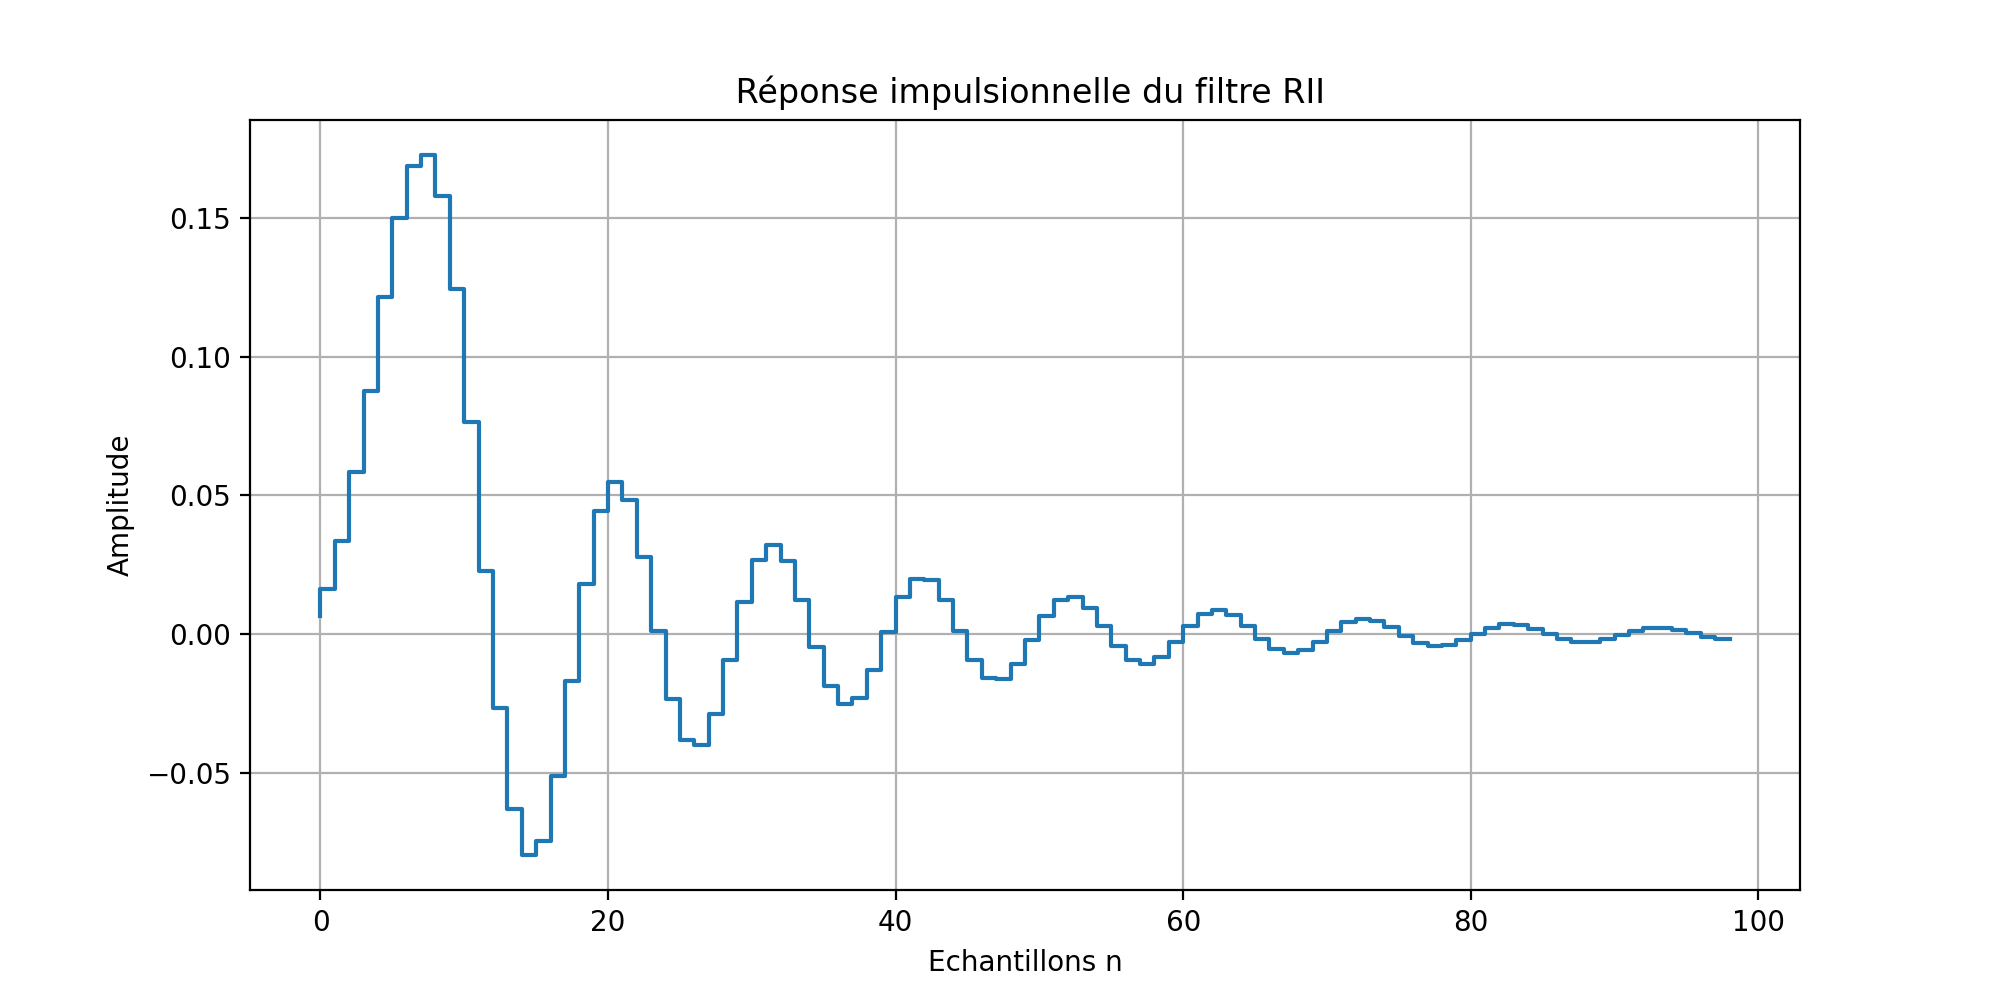

In [11]:
# Filtre RIF
n1, rep_imp1 = FILTRE1_RIF.impulse_response()
plt.figure(figsize=(10,5))
plt.step(n1, rep_imp1)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'\n Réponse impulsionnelle du filtre RIF')
plt.grid()

# Filtre RII
n2, rep_imp2 = FILTRE1_RII.impulse_response()
plt.figure(figsize=(10,5))
plt.step(n2, rep_imp2)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'\n Réponse impulsionnelle du filtre RII')
plt.grid()

Comme attendu, on constate que les échantillons de la réponse impulsionnelle du filtre RIF s'annulent tous pour n>N (ordre du filtre). A l'opposé, la réponse impulsionnelle du filtre RII ne fait que tendre vers 0. Pour le filtre RIF, on peut constater une symétrie de la réponse (qui est liée à la méthode de synthèse)

#### 2.1.6) Utiliser les filtres synthétisés pour filtrer le signal stéréophonique $x_{stereo}[n]$ et récupérer ainsi le signal monophonique $x_{mono}[n]$.

<IPython.core.display.Javascript object>


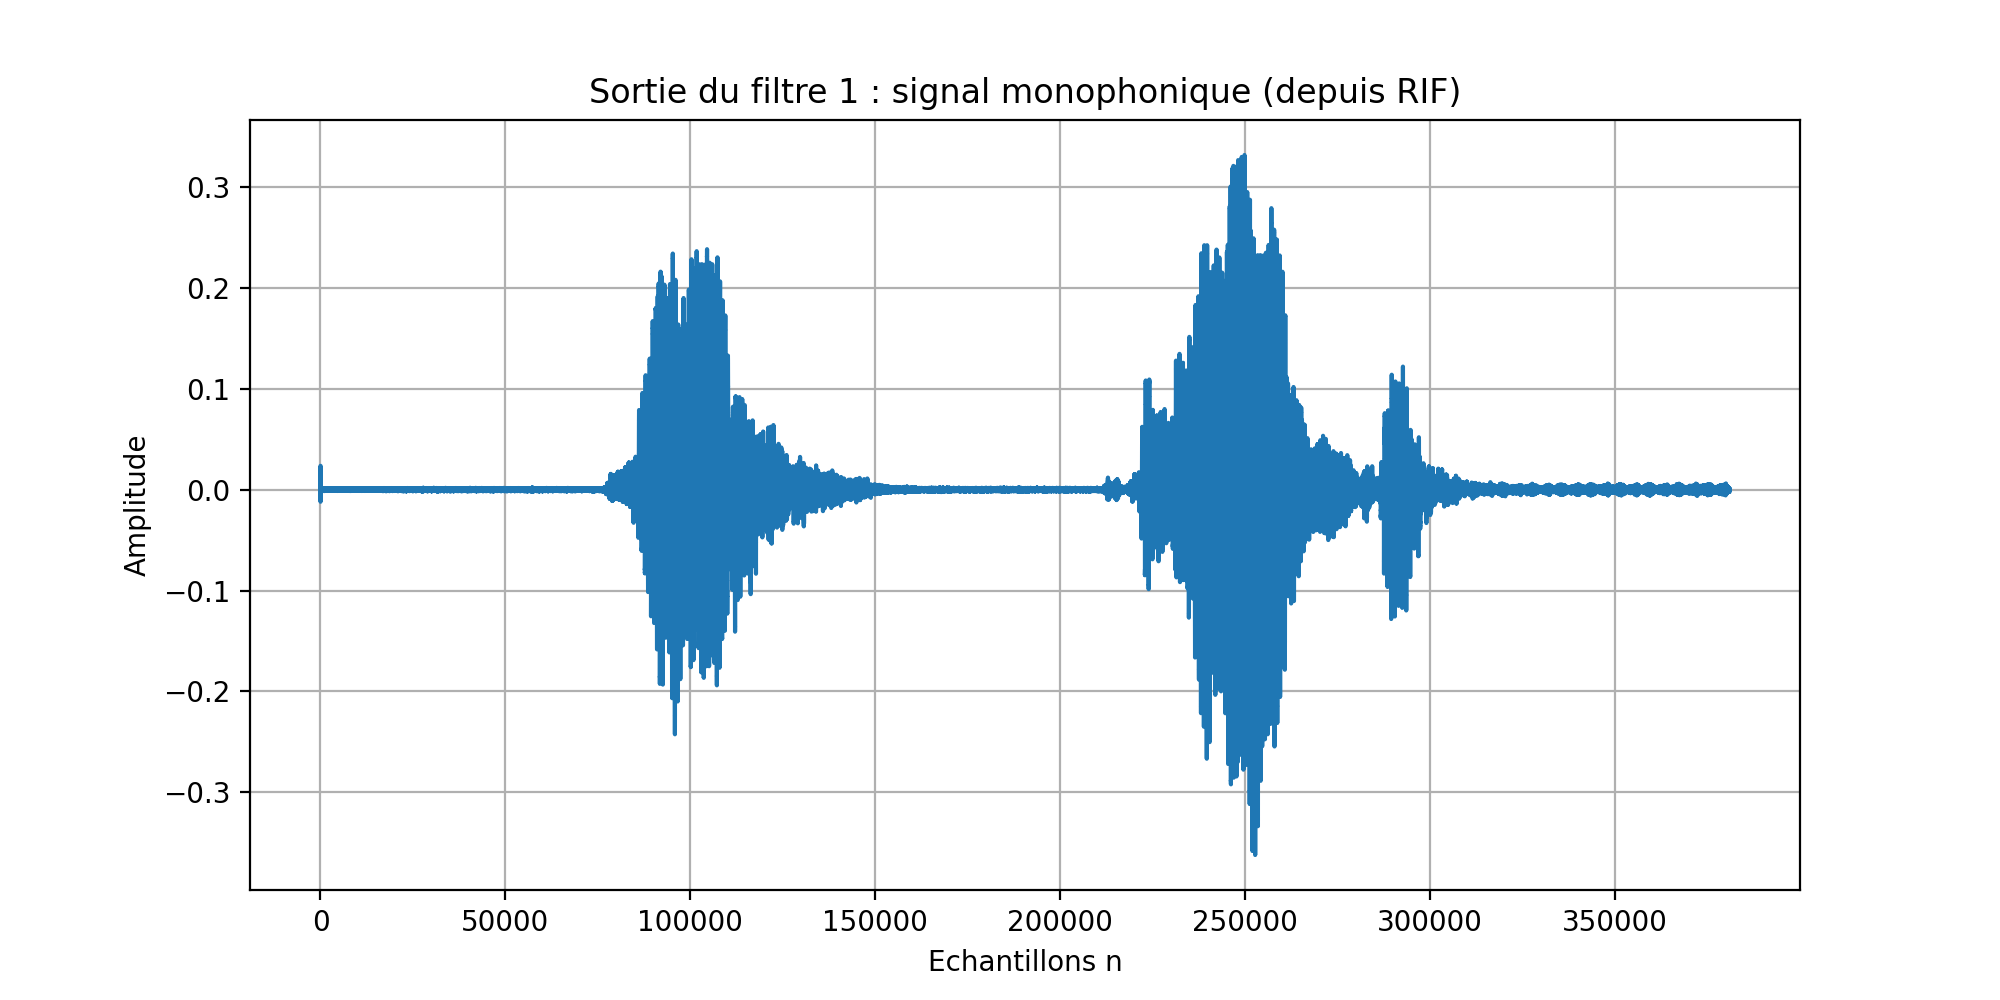

<IPython.core.display.Javascript object>


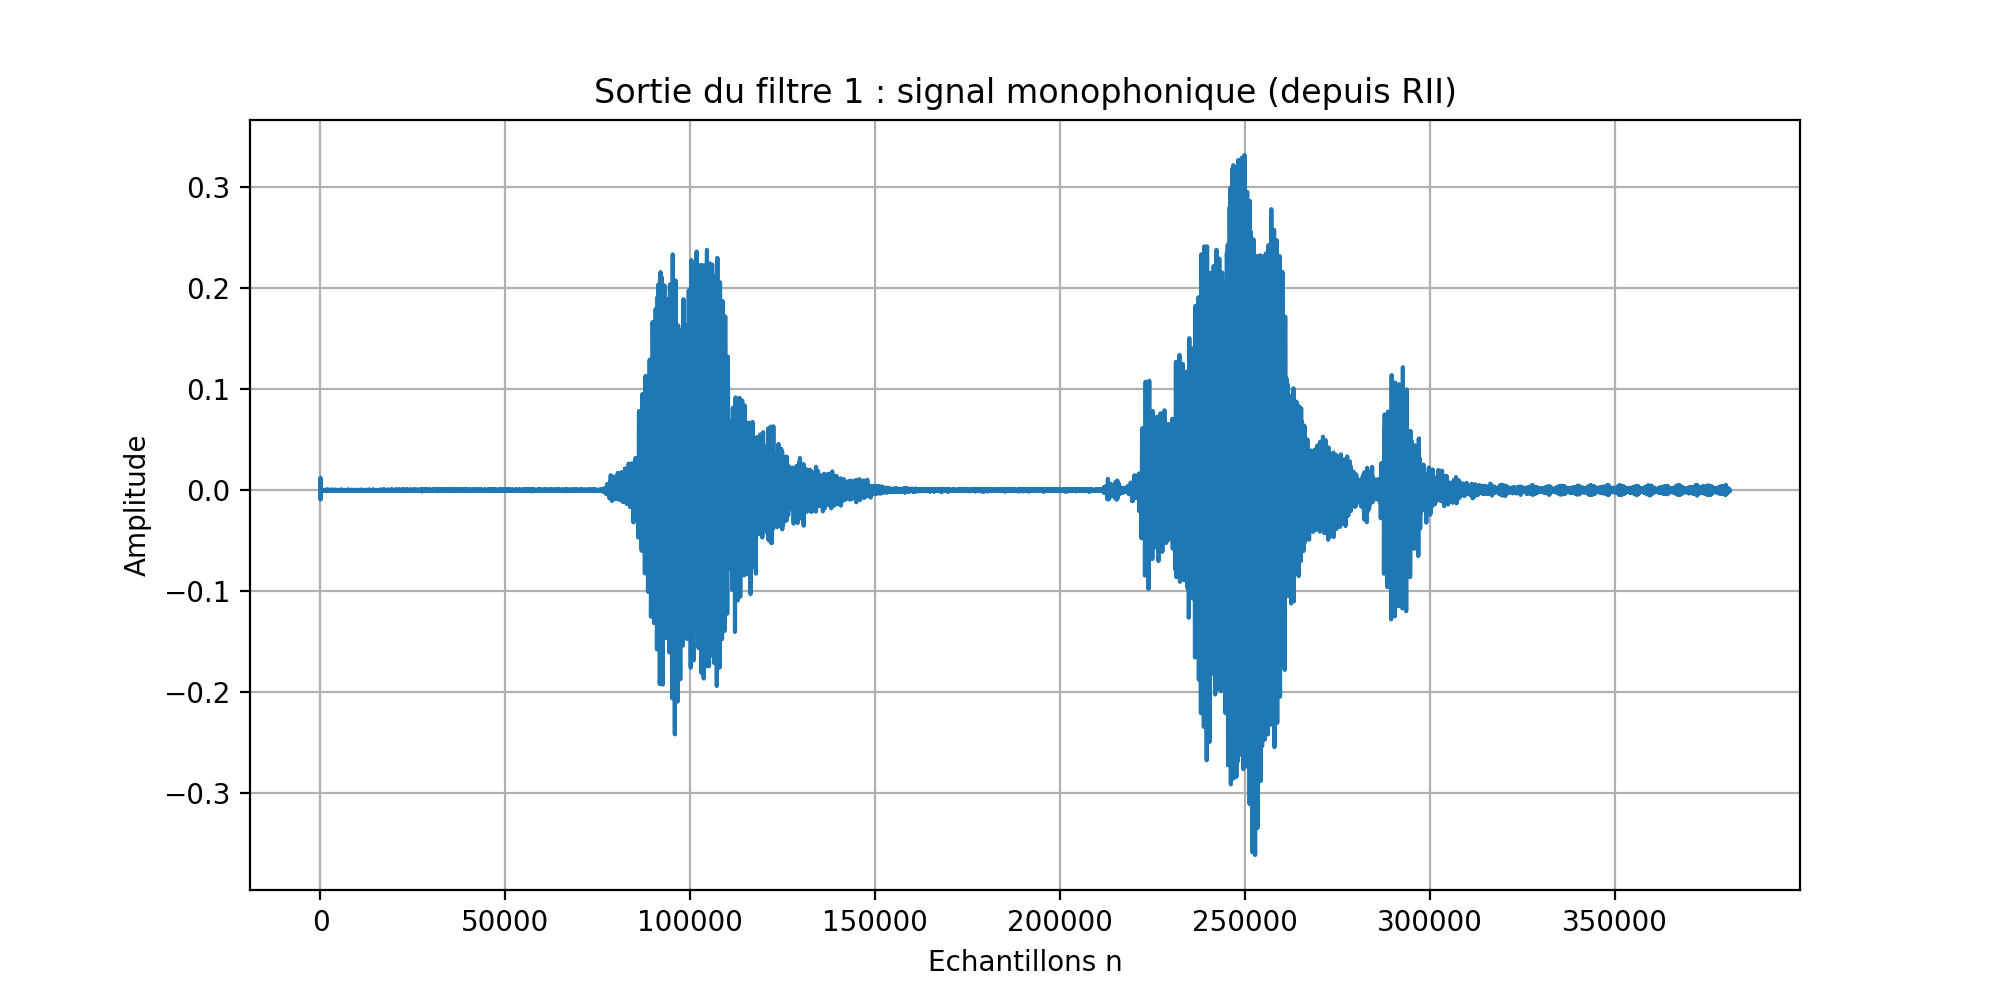

In [12]:
# Filtre RIF
n_rif, x_mono_rif = FILTRE1_RIF.filter(stereo)
plt.figure(figsize=(10,5))
plt.step(n_rif, x_mono_rif)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Sortie du filtre 1 : signal monophonique (depuis RIF)')
plt.grid()

# Filtre RII
n_rii, x_mono_rii = FILTRE1_RII.filter(stereo)
plt.figure(figsize=(10,5))
plt.step(n_rii, x_mono_rii)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Sortie du filtre 1 : signal monophonique (depuis RII)')
plt.grid()

#### 2.1.7) Déterminer et afficher le spectre du signal monophonique. Vérifier que le filtre précédent a bien supprimé les composantes fréquentielles souhaitées.

<IPython.core.display.Javascript object>


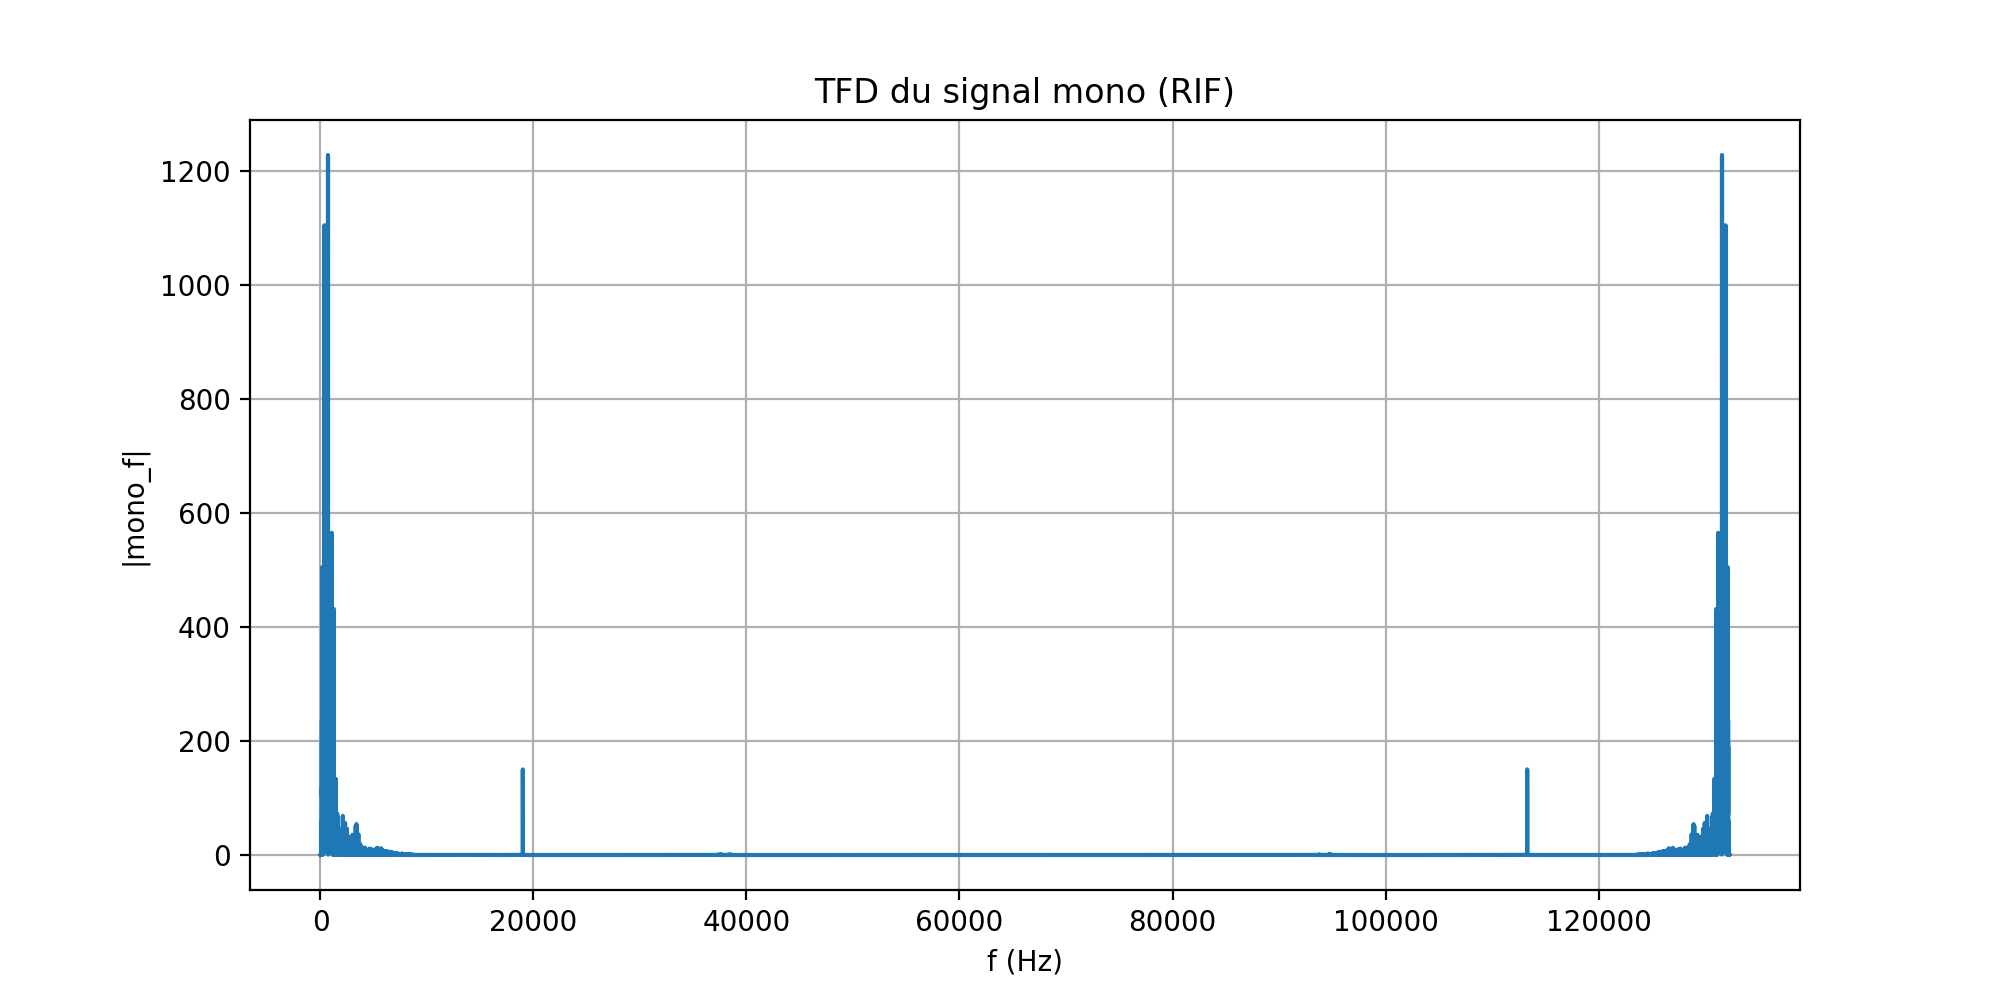

<IPython.core.display.Javascript object>


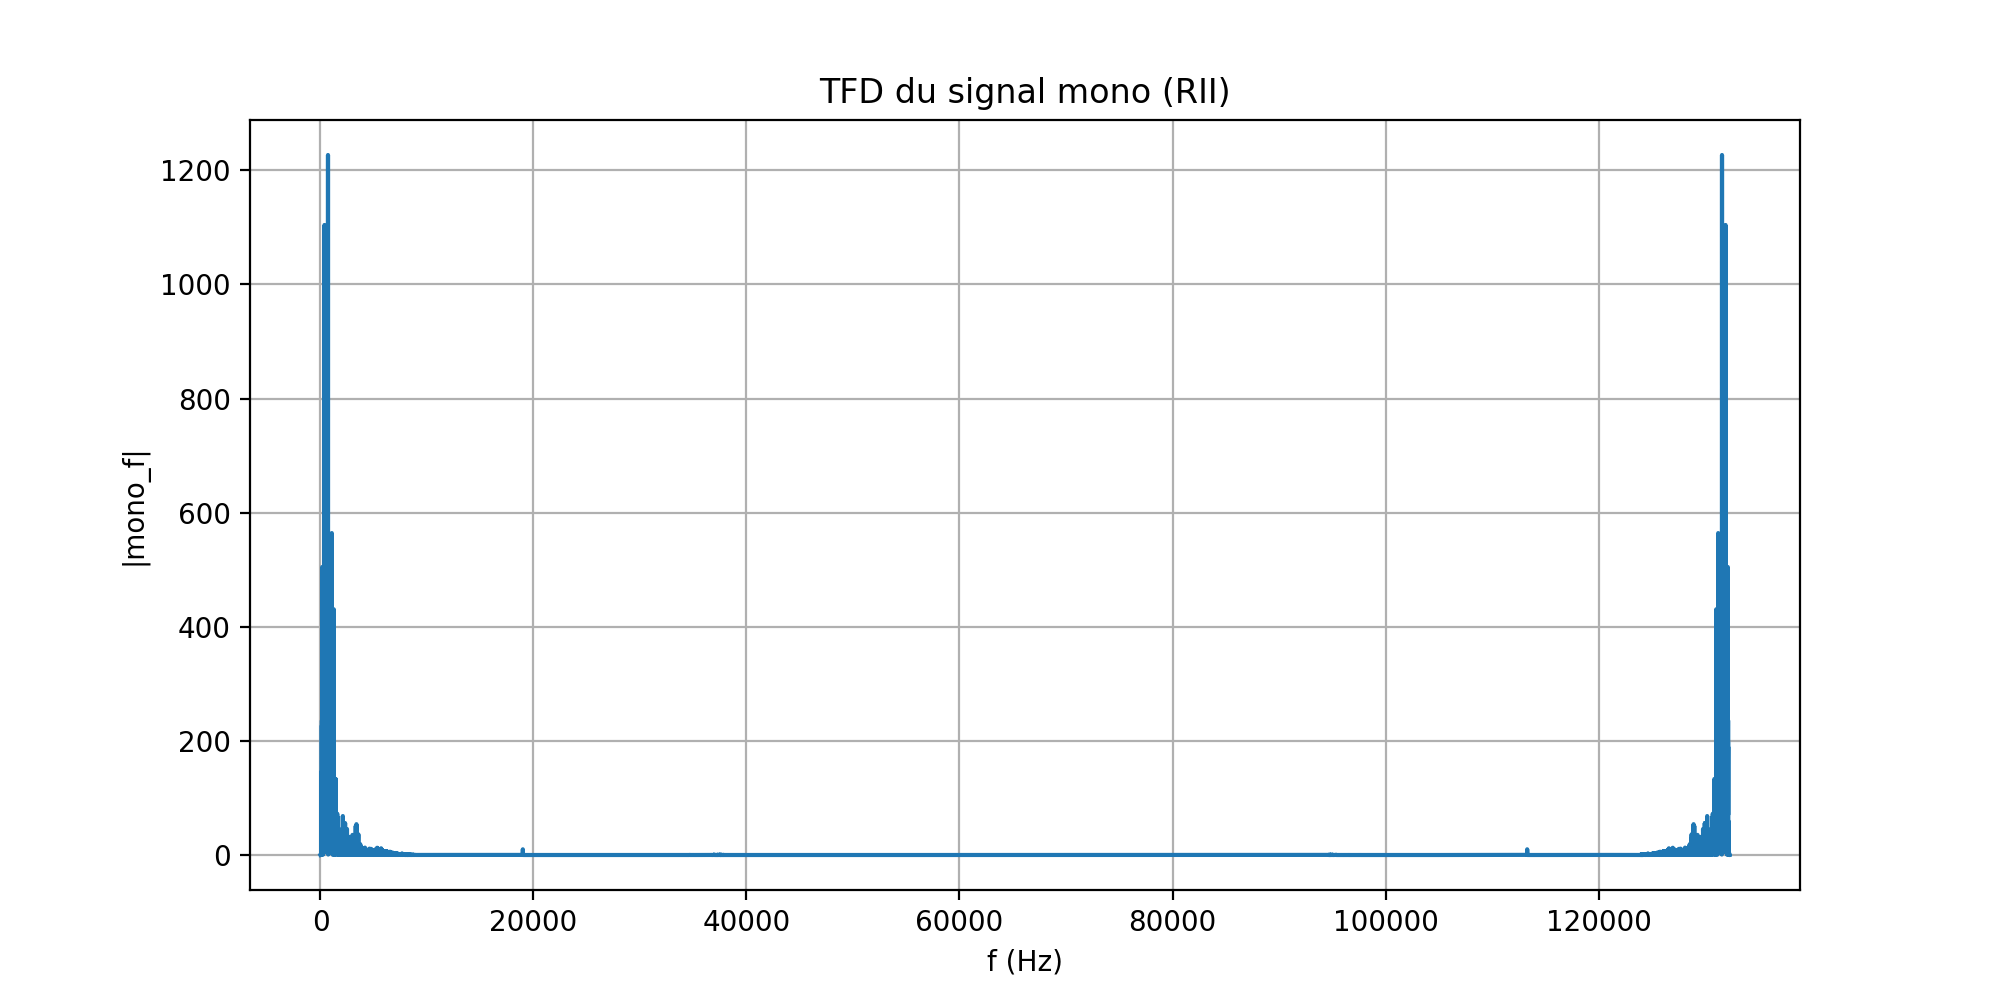

In [13]:
N = len(x_mono_rif)
f = np.arange(0,Fe,Fe/N)
mono_f_rif = np.fft.fft(x_mono_rif)
mono_f_rii = np.fft.fft(x_mono_rii)
plt.figure(figsize=(10,5))
plt.plot(f,abs(mono_f_rif))
plt.title('TFD du signal mono (RIF)'); plt.xlabel('f (Hz)'); plt.ylabel('|mono_f|'); plt.grid()
plt.figure(figsize=(10,5))
plt.plot(f,abs(mono_f_rii))
plt.title('TFD du signal mono (RII)'); plt.xlabel('f (Hz)'); plt.ylabel('|mono_f|'); plt.grid()

L'allure temporelle montre que la composante sinusoidale initalement présente dans le signal stéréo a bien été supprimée. Cela ne peut néanmoins être confirmé que sur le tracé du spectre où le pic décelé sur le spectre du signal stéréo à 19kHz a bien disparu. Par ailleurs, le signal G-D centré autour de 38kHz a normalement été également supprimé.

#### 2.1.8) Ecouter le signal monophonique et conclure.

In [17]:
display(Audio(x_mono_rif, rate=Fe))

A l'écoute, nous entendons les 2 mots "gauche" et "droite". On peut deviner que ces 2 signaux sont initialement diffusés dans les signaux G et D respectivement. Evidemment, le signal monophonique "mélange" ces 2 signaux de façon à ne pas manquer une information éventuellement transmise dans un seul de ces 2 signaux, justifant ainsi la construction du signal mono par la somme (ou différence, éventuellement) des 2 signaux G et D.

## 2.2/ Extraction de la porteuse

Nous venons de déterminer un filtre FILTRE1 permettant d'extraire du signal stéréophonique l'information monophonique G+D. Pour rappel, nous travaillons sur l'architecture suivante :
<img src="img/archi.png" width=600>
<p style="text-align: center">Fig.3 : Schéma de principe du démultiplexeur stéréo.</p>
    
Il s'agit maintenant de déterminer le filtre numérique **FILTRE2** permettant d'extraire la porteuse à 19kHz située au sein du signal stéréophonique. Cette porteuse va permettre, grâce à l'utilisation d'autres filtre snumériques (en gris sur le schéma ci-dessus), d'extraire *in fine* le signal G-D.

#### 2.2.1) Compte tenu du spectre du signal stéréophonique représenté Fig.2, préciser la nature (passe-haut, passe-bas, passe-bande) du filtre **FILTRE2** permettant d'extraire la porteuse du signal stéréo. Préciser alors son gabarit en fréquence.

Il nous faut supprimer 1/le signal mono G+D situé avant 15kHz, et 2/le signal G-D centré autour de 38kHz. D'après la figure 2, il nous faut donc réaliser un filtre passe-bande, centré en 19kHz, et apportant suffisamment d'atténuation aux fréquences 15kHz et 23kHz. Cela définit le gabarit du FILTRE2.

#### 2.2.2) Synthétiser le filtre souhaité. Tracer sa réponse en fréquence.

<IPython.core.display.Javascript object>


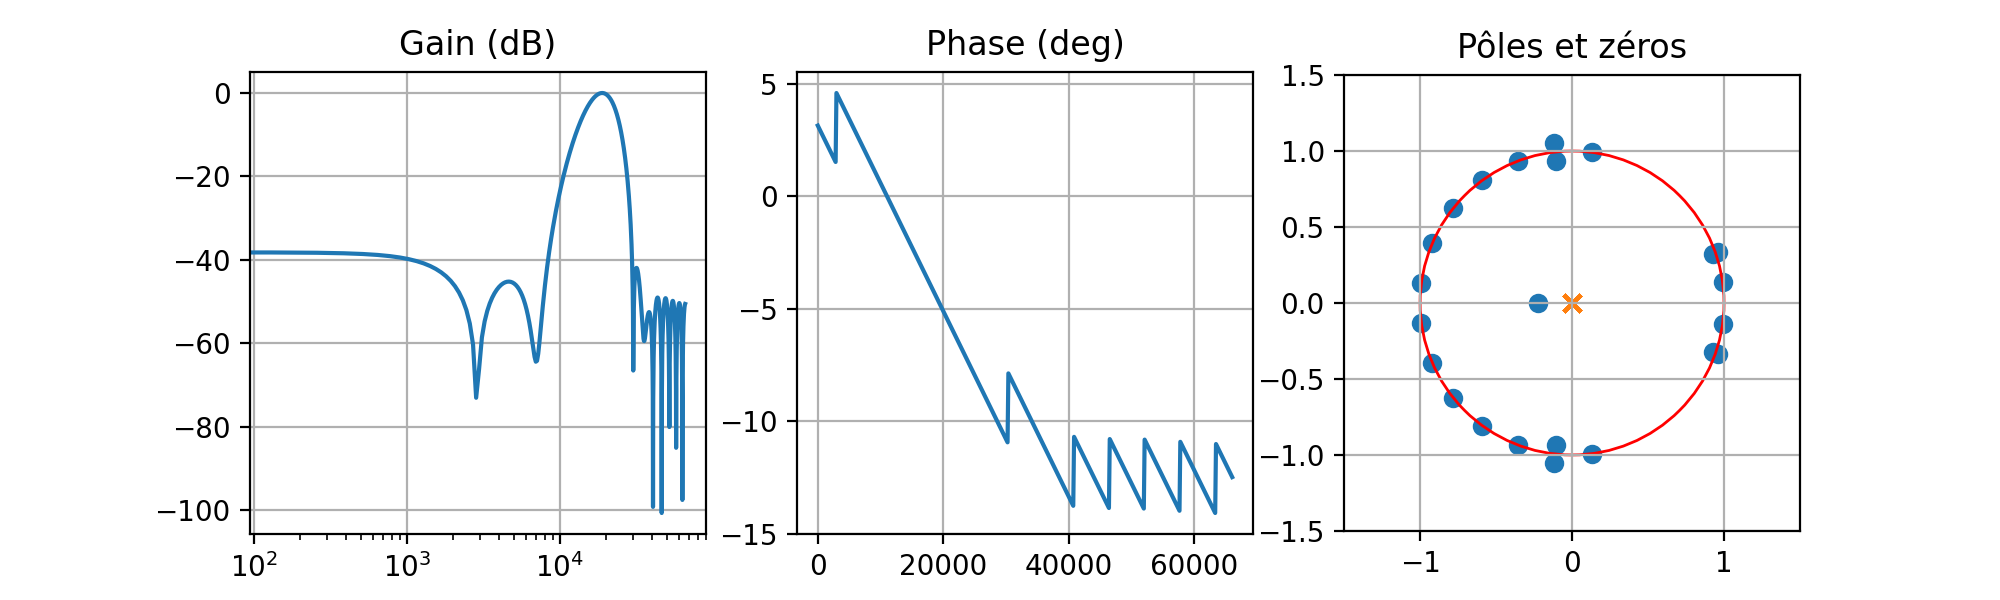

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [14]:
# Filtre2
FILTRE2 = filtre()
fig, ax = plt.subplots(1,3,figsize=(10,3))
FILTRE2.display(ax, fig)

#### 2.2.3) Filtrer le signal stéréphonique avec le filtre FILTRE2 obtenu. Vérifier son bon fonctionnement en traçant l'allure temporelle et le contenu fréquentiel de son signal de sortie. Conclure.

<IPython.core.display.Javascript object>


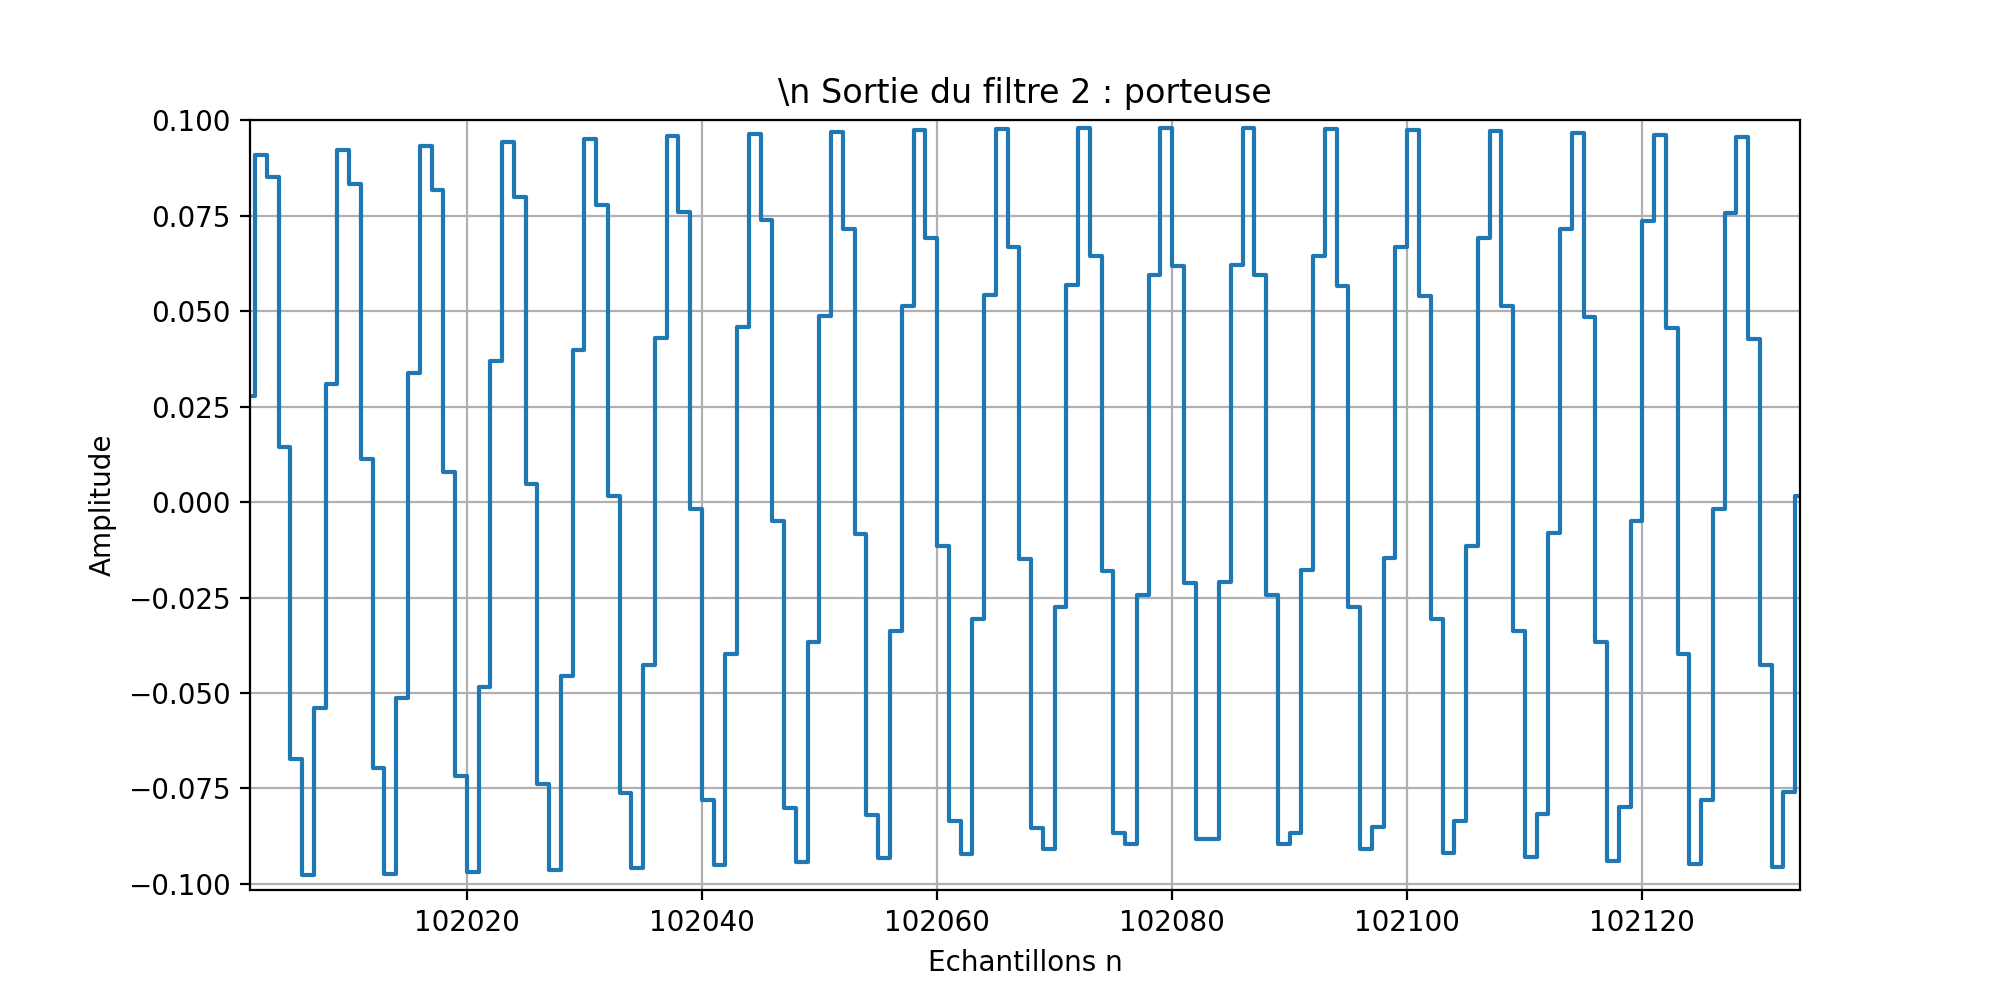

<IPython.core.display.Javascript object>


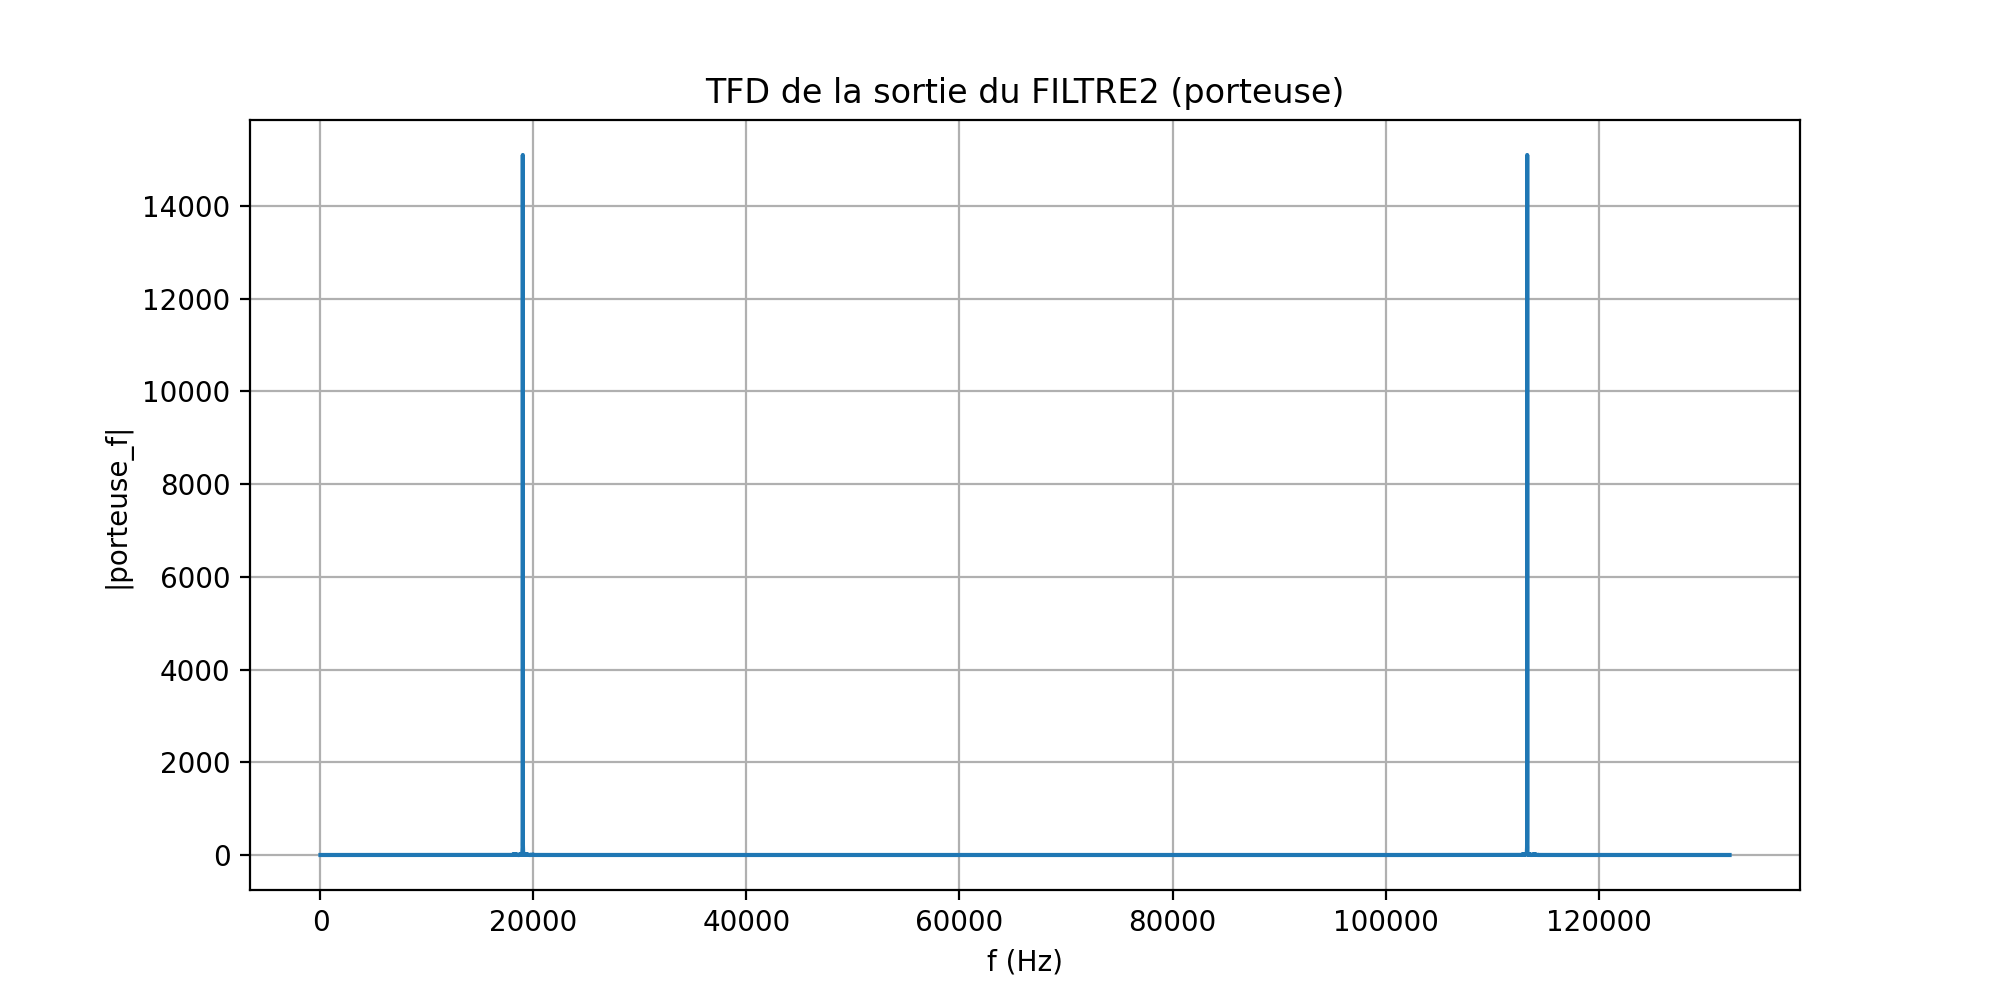

In [16]:
# Filtrage
n, porteuse = FILTRE2.filter(stereo)

# Tracé de l'allure temporelle
plt.figure(figsize=(10,5))
plt.step(n, porteuse)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'\\n Sortie du filtre 2 : porteuse')
plt.grid()

# Contenu fréquentiel
f = np.arange(0,Fe,Fe/len(porteuse))
porteuse_f = np.fft.fft(porteuse)
plt.figure(figsize=(10,5))
plt.plot(f,abs(porteuse_f))
plt.title('TFD de la sortie du FILTRE2 (porteuse)'); plt.xlabel('f (Hz)'); plt.ylabel('|porteuse_f|'); plt.grid()

*Commentaires sur le bon fonctionnement de **FILTRE2** :*

Le tracé temporel montre (en zoomant !) une sortie visiblement sous la forme d'un signal sinoidal, comme attendu. Le tracé de la TFD le confirme, le spectre du signal de sortie n'est constitué que d'une raie en 19kHz. Le filtre a bien extrait la porteuse uniquement, comme attendu.

## 2.3/ Mise en œuvre du démultiplexeur

Nous disposons maintenant des 2 filtres **FILTRE1** et **FILTRE2** nécessaire à la mise en œuvre du multiplexeur complet reproduit à nouveau sur la figure suivante.
<img src="img/archi.png" width=600>
<p style="text-align: center">Fig.3 : Schéma de principe du démultiplexeur stéréo.</p>

Il s'agit maintenenant de récupérer les 2 signaux **G+D** et **G-D** grâce à cette architecture. Pour cela, vous disposez de la fonction ```demultiplex(stereo, FILTRE1, FILTRE2)``` qui implémente pour vous l'architecture complète de la figure 3 et prend en paramètre les 2 filtres que vous avez synthétisé.

#### 2.3.1) Utiliser la fonction ```demultiplex(stereo, FILTRE1, FILTRE2)``` (en adaptant les valeurs des paramètres si nécessaire) pour extraire les 2 signaux G+D (monophonique) et G-D du signal stéréophonique.

In [17]:
# J'utilise ici volontairement le FILTRE1 de type RII
n, g_plus_d, g_moins_d = demultiplex(stereo, FILTRE1_RII, FILTRE2)

#### 2.3.2) Combiner les deux signaux G+D et G-D de façon à obtenir les signaux gauche G et droite D seuls. Tracer leurs allure temporelles.

<IPython.core.display.Javascript object>


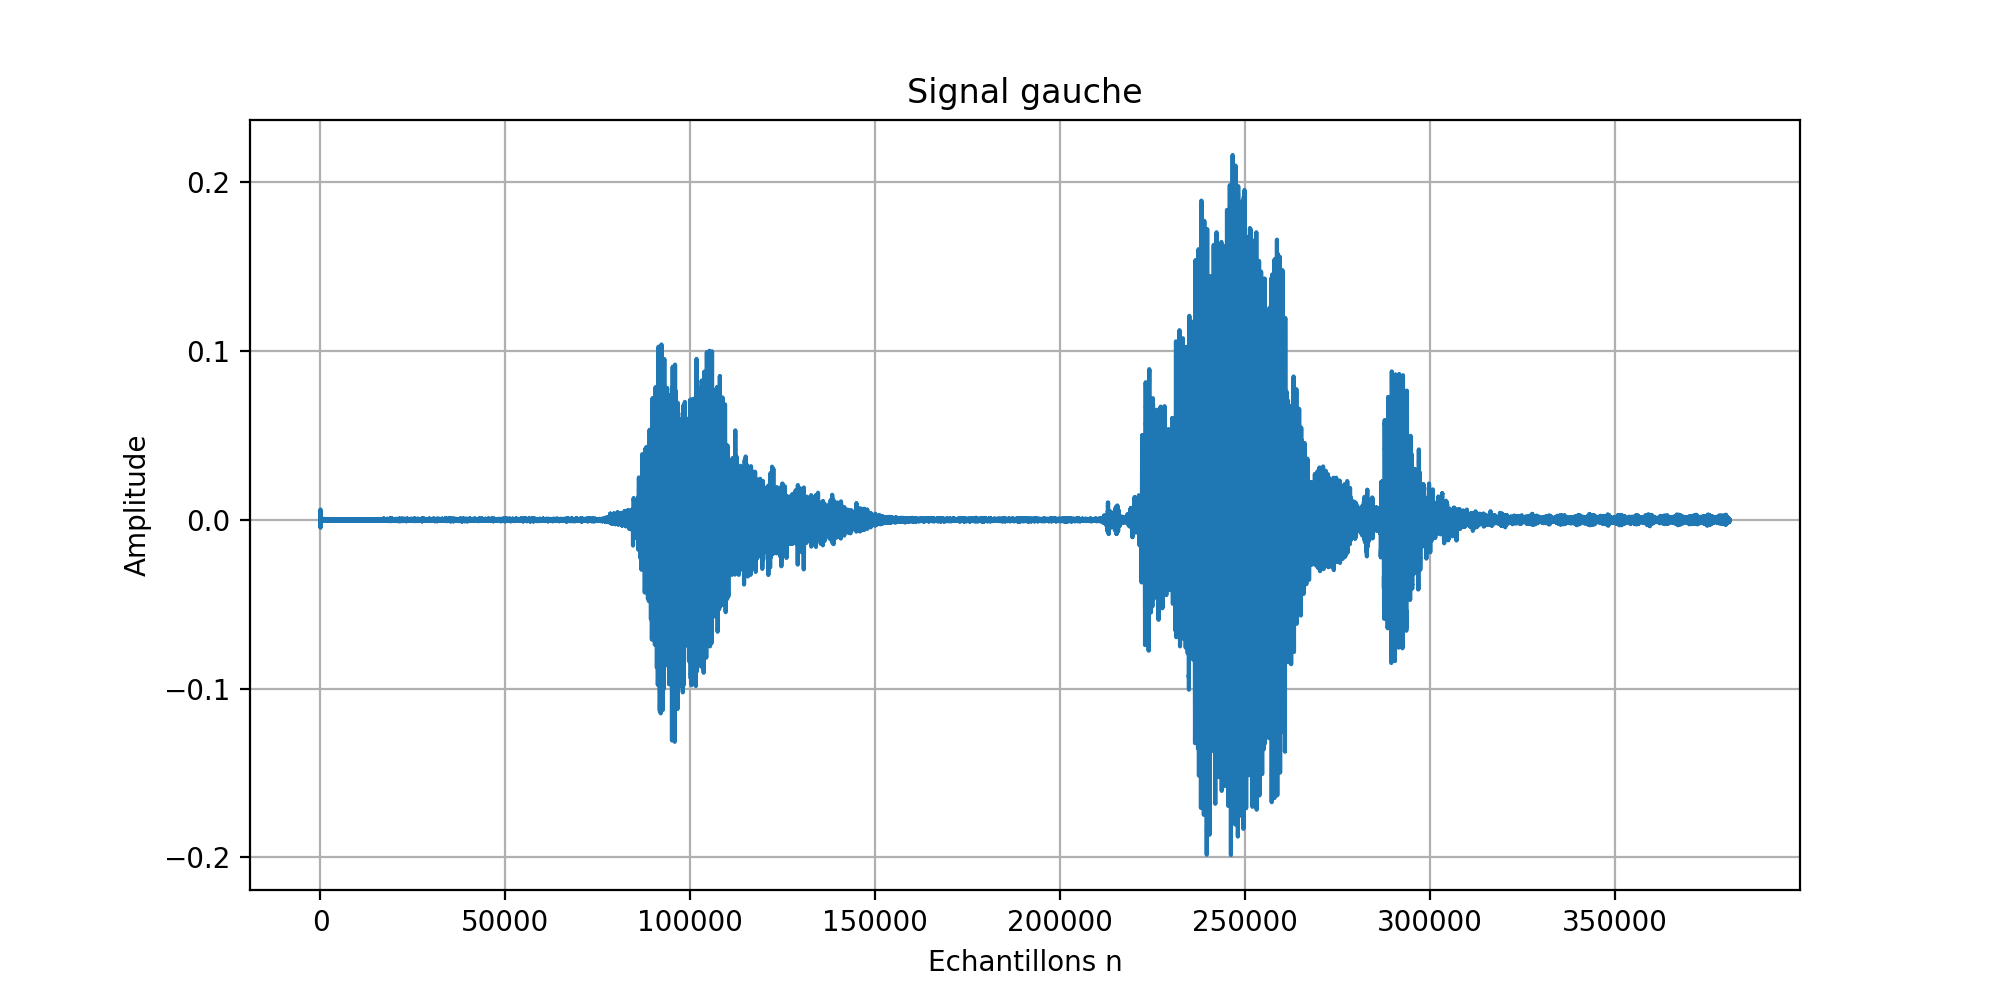

<IPython.core.display.Javascript object>


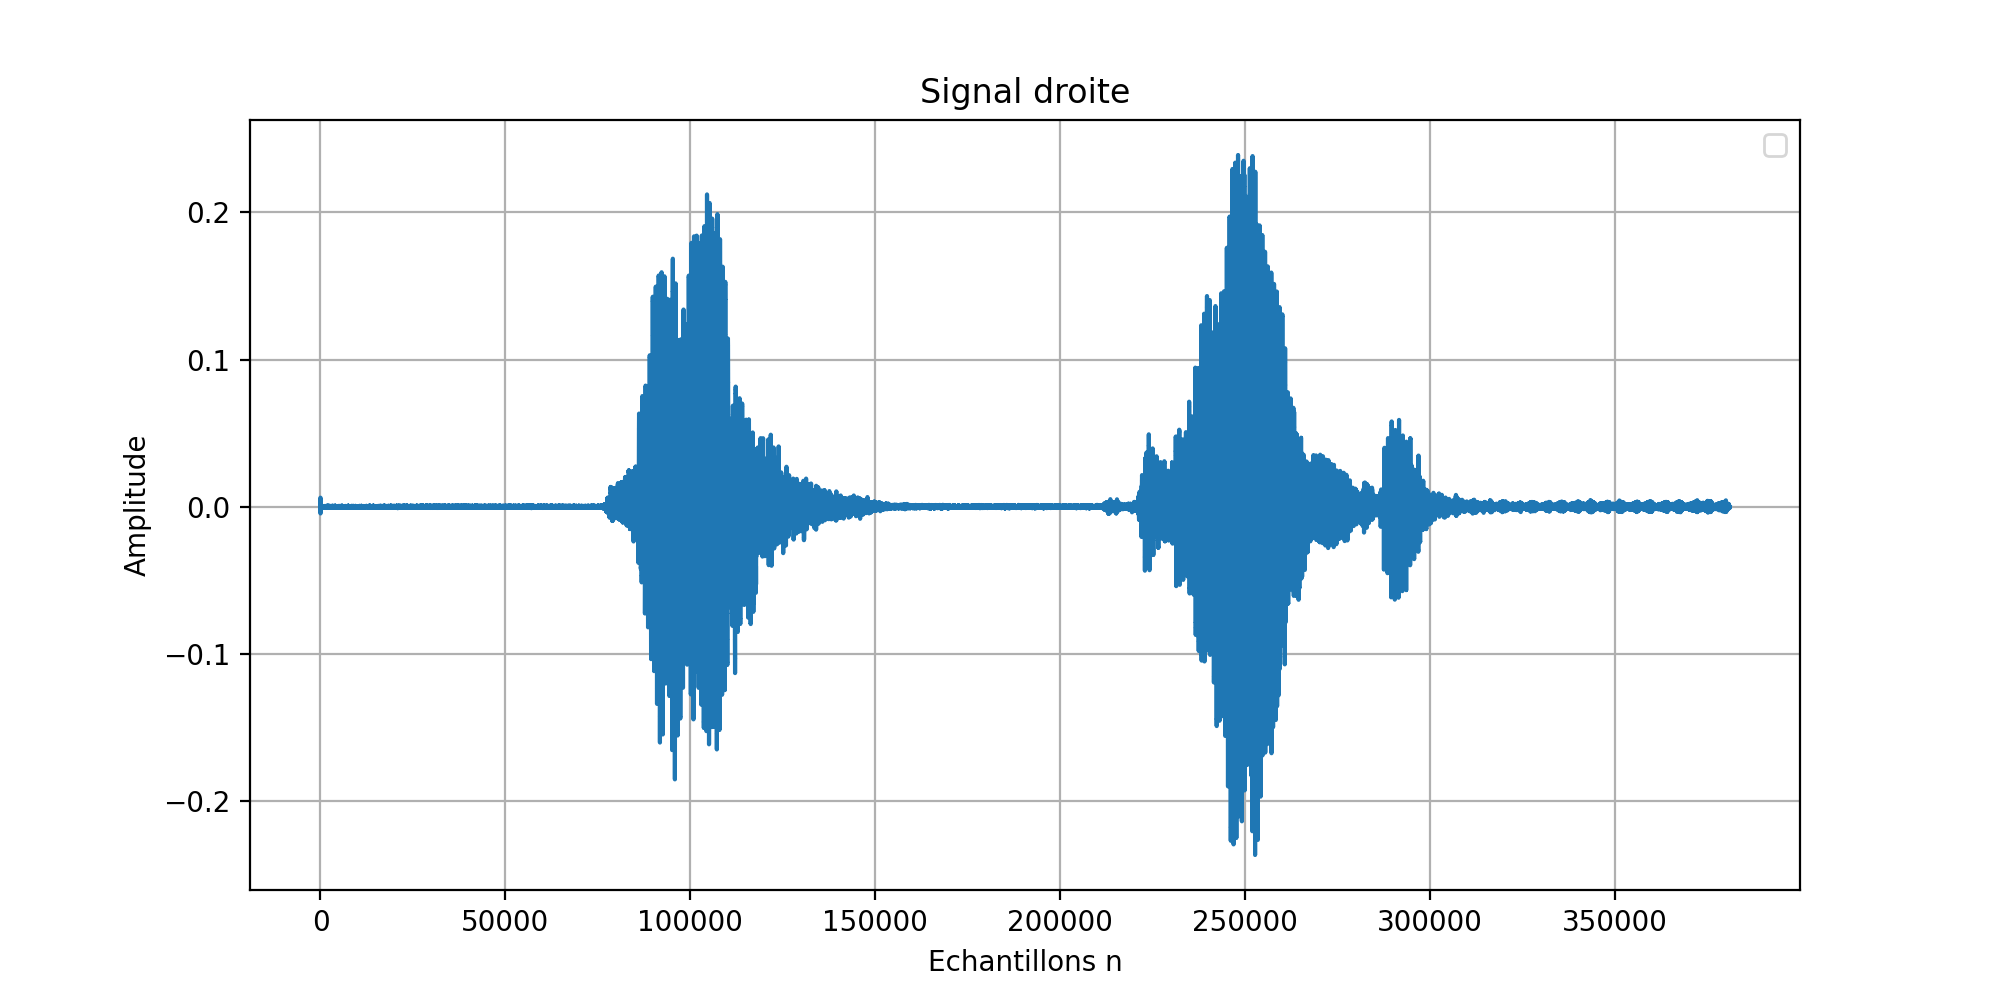

In [18]:
# Signal gauche
g = (g_plus_d + g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, g)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal gauche')
plt.grid()

# Signal droite
d = (g_plus_d - g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, d)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal droite')
plt.grid()

#### 2.3.3) Ecouter les signaux obtenus. A-t'on réussi à séparer les signaux gauche G et droite D ? Expliquer.

In [19]:
display(Audio(g, rate=Fe))
display(Audio(d, rate=Fe))

Sans attention autre que le module des réponses en fréquence, il y a peu de chance que les 2 signaux soient séparés. Comme l'indique la figure 3, l'architucture du démultiplexeur s'appuie sur des filtres placés en parallèle, pour lesquels il est nécessaire de fairte attention à la synchronisation temporelle entre chaque "branche". Or, cette synchronisation n'est possible que si nous travaillons avec des filtres à phase linéaie, possédant donc un temps de propagation de groupe constant. De plus, ce temps est directement proportionnel à l'odre des filtres RIF. Pour que l'architecture fonctionne, il faut donc que :
- le filtre FILTRE1 soit un RIF d'ordre 100
- le filtre FILTRE2 soit un RIF d'ordre 25
respectant tous 2 leurs gabarits respectifs.

#### 2.3.4) Modifier en conséquence les filtres FILTRE1 et FILTRE2 pour que le démultiplexage fonctionne correctement. Tracer l'allure des signaux obtenus, et vérifier en écoutant les signaux que les modifications apportées fonctionnent. Conclure

<IPython.core.display.Javascript object>


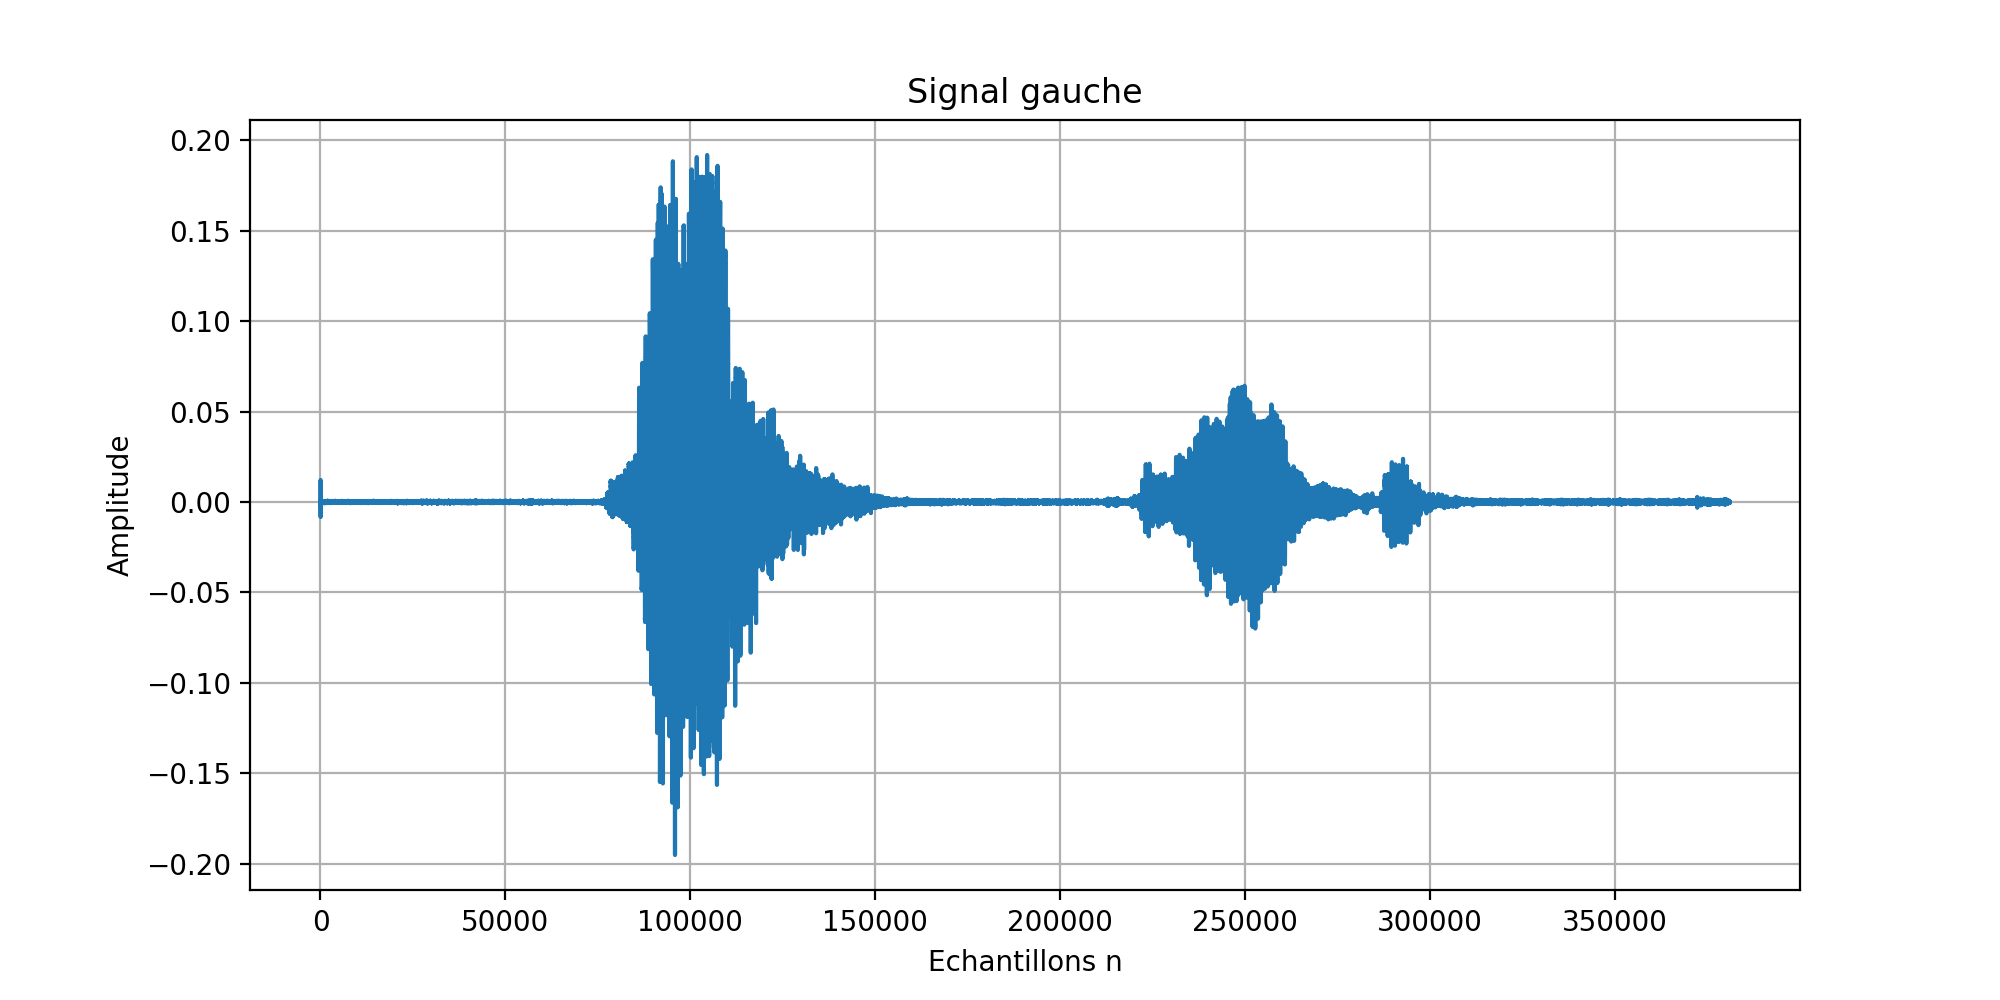

<IPython.core.display.Javascript object>


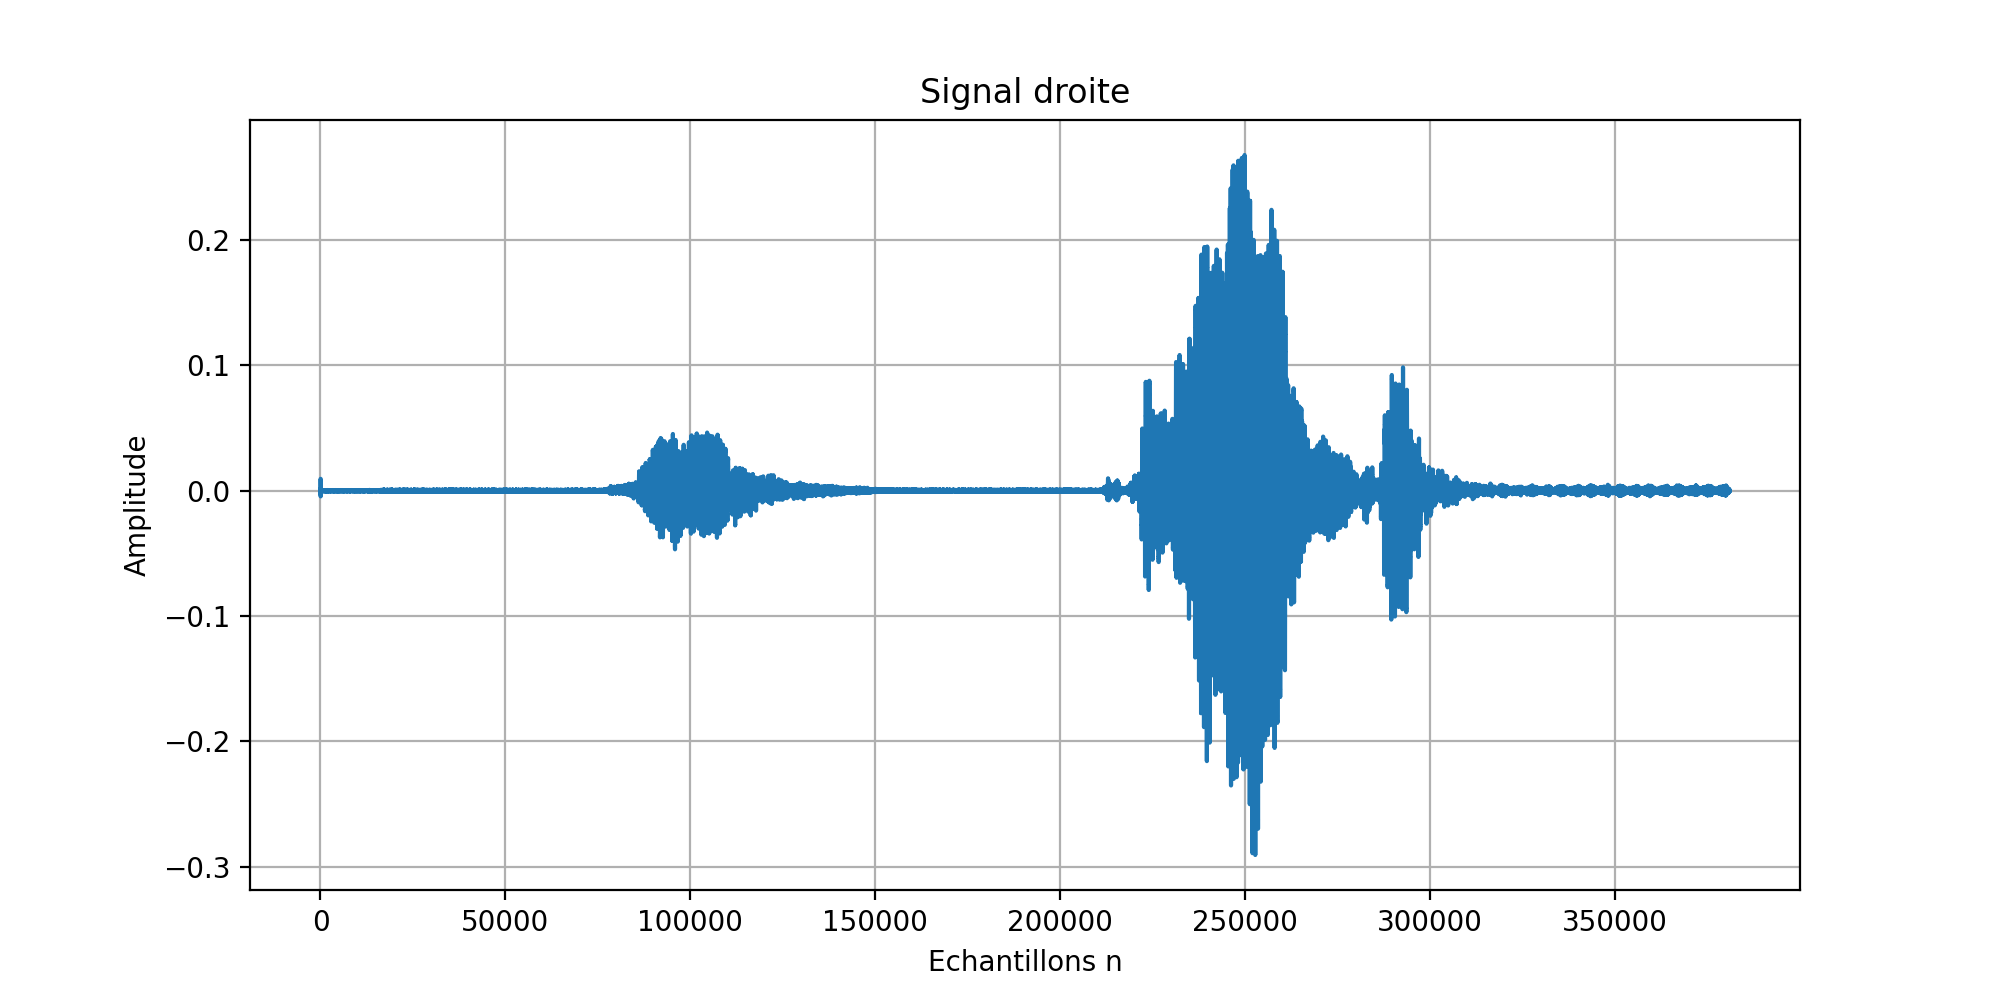

In [20]:
n, g_plus_d, g_moins_d = demultiplex(stereo, FILTRE1_RIF, FILTRE2)
# Signal gauche
g = (g_plus_d + g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, g)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal gauche')
plt.grid()

# Signal droite
d = (g_plus_d - g_moins_d)/2
plt.figure(figsize=(10,5))
plt.step(n, d)
plt.xlabel('Echantillons n')
plt.ylabel('Amplitude')
plt.title(u'Signal droite')
plt.grid()

display(Audio(g, rate=Fe))
display(Audio(d, rate=Fe))

# Si on envoie le signal g à gauche, et d à droite :
display(Audio([g,d], rate=Fe))

En faisant attention au type de filtre (RIF) ainsi qu'à l'ordre, la séparation des voies G et D est maintenant effective. Même si nous ne traçons souvent que le module de la réponse en fréquence des filtres, la caractéristique de phase est donc réellement importante selon l'application envisagée ! 